# Task 1: To process EEG signals and classify user confirmed flickering frequencies

This experiment shows user response to 4 different flickering frequencies (7.5 Hz, 8.25 Hz, 10 Hz, 12 Hz). We want to capture the EEG segments where the user was focused at a particular flicker frequency stimuli. We will classify the eeg segments based on user focused stimuli.

Important event_ids -

1: 7.5 Hz flicker stimuli active

2: 8.25 Hz flicker stimuli active

3: 10 Hz flicker stimuli active

4: 12 Hz flicker stimuli active

10001: user CONFIRMING 7.5 Hz flicker stimuli as focused target

999: user conforming no flicker stimuli as focused target

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# 1. Import Libraries

In [3]:
# Libraries
import pandas as pd
import glob
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from scipy.signal import butter, filtfilt, freqz, iirnotch
import pywt
from pywt import wavedec
from scipy.stats import entropy

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.svm import OneClassSVM

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch

In [4]:
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    # Normalize the confusion matrix by row (i.e., by the number of samples in each class)
    #cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create the heatmap
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=True,
                xticklabels=classes, yticklabels=classes)

    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



# 2. Creating dataset from files

First combining all 14 parquet files into one BIG dataframe

In [5]:
parquet_dir = '/content/drive/MyDrive/Myelin-H/eeg_data-3/eeg_data-3/ssvep'

# Find all parquet files in the directory
parquet_files = glob.glob(os.path.join(parquet_dir, "*.parquet"))

# empty list to store DataFrames
dataframes = []

for file in parquet_files:
    df = pd.read_parquet(file)
    #display(df)
    dataframes.append(df)  # append mini dataframes to one BIG dataframe

combined_df = pd.concat(dataframes, ignore_index=True)
display(combined_df)


,i,timestamp,event_id,eeg_counter,o1,o2,t3,t4
0,0,2024-03-28 16:14:01.730662,10000.0,NaN,NaN,NaN,NaN,NaN
1,1,NaT,NaN,1272.0,0.000000,0.025809,0.000000,0.000000
2,2,2024-03-28 16:14:01.818020,NaN,1272.0,0.012500,0.038309,0.012500,0.012500
3,3,NaT,NaN,1273.0,0.078686,0.079754,0.062611,0.075636
4,4,2024-03-28 16:14:01.827110,NaN,1273.0,0.078716,0.079817,0.062636,0.075694
...,...,...,...,...,...,...,...,...
468613,50165,2024-03-28 15:44:44.943123,NaN,1513.0,0.066745,0.063988,0.049297,0.062540
468614,50166,NaT,NaN,1514.0,0.066745,0.063983,0.049343,0.062665
468615,50167,2024-03-28 15:44:44.957228,NaN,1514.0,0.066731,0.063979,0.049362,0.062741
468616,50168,NaT,NaN,1515.0,0.066727,0.063977,0.049241,0.062437


Finding unique event_ids in this dataset

In [6]:
combined_df['event_id'].unique()

array([1.0000e+04,        nan, 2.0000e+00, 3.0000e+00, 4.0000e+00,
       1.0000e+00, 9.9900e+02, 1.0001e+04])

**Notes**

1. Event id = 1, 2, 3, 4 only represent the starting time of the stimuli: 7.5 Hz, 8.25 Hz, 10 Hz, 12 Hz respectively. The 5 seconds duration after the stimuli start point is what we'll capture for analysis.
2. From the above combined dataset, event id = 10001 and event_id = 999 are the **only 2 user-confirmed classes**, representing user focused on stimuli 7.5 Hz and none respectively.
(event_id = 10002, 10003, 10004 not visible).

3. The **eeg segments** that we care about is

    *   Starting time: When the flickering stimuli was active (event_id = 1, 2, 3, 4)
    *   Ending time: When user confirms the stimuli (event_id = 10001, 999)
    *    This means that no matter what flickering stimuli was active, the **eeg response** would only correspond to the flickering frequency that the **user was focusing at**, which is confirmed by the user-confirmed event_id.

4. This dataset only has 2 user-confirmed classes: 10001 (confirmed 7.5 Hz frequency) and 999 (0 Hz). So we make this a binary classification problem to differentiate the two.



Using the above idea, the epochs_data function was created by the following steps:

1. Get a dataframe from a single parquet file.
2. Find the starting event_id = 1, 2, 3, 4
3. Extract the following 5 seconds eeg data ('o1', 'o2', 't3', 't4') using indexing (num_samples = 5 * sampling rate). Sampling rate = 250 Hz.
4. Add the extracted eeg segment into a new dataframe. Each row represents a specific channel data.
5. If the next occurring event_id after the starting event_id is 10001, label the extracted eeg channel data as '10001' in new dataframe. Else if the next occuring event_id is 999, label as '999'.
6. Keeping adding in channel data by starting at every event_id = 1, 2, 3, 4, until you reach end of dataframe.
7. Iterate over 13 parquet files.

In [7]:
# defining create segments function

def create_segments(df, start_event_ids, end_event_ids, sampling_rate=250):
    segment_duration = 5  # seconds
    num_samples = segment_duration * sampling_rate  # Calculate number of samples per 5 seconds for indexing
    epochs_list = []

    # Iterate over each starting event ID
    for start_event_id in start_event_ids:

        start_events = df[df['event_id'] == start_event_id] # finding starting event_id = 1, 2, 3, 4

        for index, start_row in start_events.iterrows():
            start_index = index + 1                         # start index ( + 1 because the eeg value is NaN at event_id index itself)
            end_index = start_index + num_samples           # end index is 5 seconds after start index

            subsequent_events = df.loc[start_index:]        # finding first occurrence of event_id = 10001 or 999 after start event_id
            end_event = subsequent_events[subsequent_events['event_id'].isin(end_event_ids)]
            label = end_event['event_id'].iloc[0] if not end_event.empty else None

            # Slice to get index window for 5 seconds of data
            epoch_df = df.loc[start_index:start_index + int(5 * sampling_rate), ['o1', 'o2', 't3', 't4']]
            #print(epoch_df)

            if not epoch_df.empty:
                for channel in ['o1', 'o2', 't3', 't4']:
                    channel_data = epoch_df[channel].tolist()
                    epochs_list.append(channel_data + [label])

    # Creating DataFrame
    num_samples = int(5 * sampling_rate)

    confirmed_epochs_df = pd.DataFrame(epochs_list)

    return confirmed_epochs_df



# trying with one example
start_event_ids = [1, 2, 3, 4]  # start event_ids
end_event_ids = [10001, 999]    # end event_ids

df0 = pd.read_parquet('/content/drive/MyDrive/Myelin-H/eeg_data-3/eeg_data-3/ssvep/0.parquet')
epochs_df0 = create_segments(df0, start_event_ids, end_event_ids)  # example for df0 (0.parquet file)
epochs_df0


,0,1,2,3,4,5,6,7,8,9,...,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251
0,0.042902,0.043193,0.043561,0.044275,0.043613,0.042907,0.043206,0.043568,0.044269,0.043586,...,0.043387,0.043700,0.044290,0.044601,0.043558,0.043398,0.043716,0.044300,0.044596,999.0
1,0.039263,0.039471,0.039749,0.040274,0.039797,0.039267,0.039480,0.039752,0.040283,0.039798,...,0.039703,0.039936,0.040375,0.040617,0.039849,0.039714,0.039947,0.040385,0.040614,999.0
2,0.024696,0.026492,0.027833,0.029391,0.025420,0.024757,0.026521,0.027727,0.029483,0.025368,...,0.025953,0.027032,0.029359,0.028462,0.024503,0.026005,0.027084,0.029248,0.028529,999.0
3,0.030609,0.035111,0.038163,0.041592,0.032461,0.030731,0.035275,0.037700,0.041990,0.032397,...,0.033352,0.036086,0.041193,0.039082,0.030030,0.033533,0.036266,0.040659,0.039306,999.0
4,0.046248,0.045266,0.045409,0.045711,0.046442,0.046243,0.045252,0.045403,0.045709,0.046442,...,0.046521,0.045485,0.045550,0.045851,0.046548,0.046509,0.045472,0.045556,0.045861,999.0
5,0.042216,0.041484,0.041569,0.041801,0.042347,0.042216,0.041478,0.041573,0.041803,0.042347,...,0.042609,0.041843,0.041875,0.042104,0.042625,0.042608,0.041837,0.041882,0.042106,999.0
6,0.028916,0.026315,0.028217,0.029242,0.031726,0.028834,0.026226,0.028349,0.029269,0.031671,...,0.029605,0.026505,0.028339,0.029348,0.031853,0.029516,0.026397,0.028478,0.029374,999.0
7,0.038091,0.032152,0.036404,0.038901,0.044263,0.037877,0.031728,0.036860,0.038966,0.044098,...,0.039357,0.032391,0.036434,0.038936,0.044281,0.039198,0.032051,0.036927,0.038989,999.0
8,0.041932,0.042250,0.043004,0.042645,0.041705,0.041914,0.042230,0.042979,0.042603,0.041706,...,0.041665,0.042113,0.042702,0.041821,0.041352,0.041670,0.042128,0.042699,0.041803,999.0
9,0.037388,0.037627,0.038186,0.037938,0.037246,0.037391,0.037630,0.038186,0.037929,0.037261,...,0.037626,0.037960,0.038397,0.037759,0.037400,0.037631,0.037970,0.038392,0.037744,999.0


Looping function over 13 parquet files to get BIG segments dataframe (events_df)

In [8]:
parquet_dir = '/content/drive/MyDrive/Myelin-H/eeg_data-3/eeg_data-3/ssvep'

parquet_files = glob.glob(os.path.join(parquet_dir, "*.parquet"))

events_df = []

start_event_ids = [1, 2, 3, 4]
end_event_ids = [10001, 999]  # Ending events are for labeling

for file in parquet_files:
    df = pd.read_parquet(file)
    epochs_df = create_segments(df, start_event_ids, end_event_ids)
    #display(epochs_df)
    events_df.append(epochs_df)

events_df = pd.concat(events_df, ignore_index=True)
display(events_df)

,0,1,2,3,4,5,6,7,8,9,...,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251
0,0.078397,0.078390,0.078389,0.078391,0.078386,0.078389,0.078393,0.078384,0.078382,0.078390,...,0.078349,0.078351,0.078352,0.078349,0.078355,0.078330,0.078321,0.078328,0.078335,999.0
1,0.076098,0.076094,0.076084,0.076083,0.076080,0.076086,0.076086,0.076080,0.076095,0.076091,...,0.076051,0.076041,0.076040,0.076040,0.076037,0.076037,0.076040,0.076045,0.076052,999.0
2,0.062841,0.062851,0.062904,0.062765,0.062853,0.062848,0.062889,0.062756,0.062878,0.062880,...,0.062807,0.062808,0.062878,0.062717,0.062820,0.062808,0.062810,0.062721,0.062823,999.0
3,0.075959,0.076015,0.076169,0.075773,0.076023,0.076018,0.076143,0.075720,0.076084,0.076093,...,0.075938,0.075940,0.076121,0.075678,0.075994,0.075987,0.076008,0.075723,0.076025,999.0
4,0.078154,0.078154,0.078153,0.078152,0.078154,0.078154,0.078156,0.078161,0.078154,0.078143,...,0.078201,0.078208,0.078211,0.078203,0.078207,0.078219,0.078207,0.078201,0.078202,999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.060828,0.061092,0.061097,0.061039,0.060920,0.061090,0.061100,0.060926,0.061023,0.061052,...,0.060928,0.061175,0.061197,0.061065,0.061048,0.061170,0.061190,0.060994,0.061118,999.0
496,0.066561,0.066563,0.066567,0.066563,0.066563,0.066556,0.066548,0.066549,0.066554,0.066553,...,0.066703,0.066703,0.066706,0.066708,0.066707,0.066710,0.066707,0.066706,0.066714,10001.0
497,0.063833,0.063834,0.063829,0.063824,0.063825,0.063826,0.063817,0.063813,0.063823,0.063825,...,0.063924,0.063927,0.063928,0.063932,0.063926,0.063923,0.063917,0.063918,0.063925,10001.0
498,0.048969,0.048999,0.048894,0.048963,0.048966,0.048995,0.048859,0.048967,0.048974,0.048972,...,0.049046,0.049082,0.048961,0.049047,0.049051,0.049082,0.048954,0.049067,0.049076,10001.0


Reformating dataframe

In [9]:
events_df = events_df.rename(columns={events_df.columns[-1]: 'target'})
events_df['target'] = np.round(events_df['target']).astype(int)

events_df.head(50)

,0,1,2,3,4,5,6,7,8,9,...,1242,1243,1244,1245,1246,1247,1248,1249,1250,target
0,0.078397,0.078390,0.078389,0.078391,0.078386,0.078389,0.078393,0.078384,0.078382,0.078390,...,0.078349,0.078351,0.078352,0.078349,0.078355,0.078330,0.078321,0.078328,0.078335,999
1,0.076098,0.076094,0.076084,0.076083,0.076080,0.076086,0.076086,0.076080,0.076095,0.076091,...,0.076051,0.076041,0.076040,0.076040,0.076037,0.076037,0.076040,0.076045,0.076052,999
2,0.062841,0.062851,0.062904,0.062765,0.062853,0.062848,0.062889,0.062756,0.062878,0.062880,...,0.062807,0.062808,0.062878,0.062717,0.062820,0.062808,0.062810,0.062721,0.062823,999
3,0.075959,0.076015,0.076169,0.075773,0.076023,0.076018,0.076143,0.075720,0.076084,0.076093,...,0.075938,0.075940,0.076121,0.075678,0.075994,0.075987,0.076008,0.075723,0.076025,999
4,0.078154,0.078154,0.078153,0.078152,0.078154,0.078154,0.078156,0.078161,0.078154,0.078143,...,0.078201,0.078208,0.078211,0.078203,0.078207,0.078219,0.078207,0.078201,0.078202,999
5,0.076062,0.076066,0.076067,0.076070,0.076074,0.076066,0.076063,0.076067,0.076070,0.076067,...,0.076013,0.076018,0.076017,0.076016,0.076017,0.076028,0.076021,0.076012,0.076016,999
6,0.062391,0.062412,0.062330,0.062326,0.062375,0.062424,0.062298,0.062372,0.062370,0.062409,...,0.062359,0.062394,0.062276,0.062319,0.062344,0.062407,0.062251,0.062358,0.062350,999
7,0.076004,0.076066,0.075866,0.075848,0.075964,0.076077,0.075739,0.075943,0.075952,0.076073,...,0.075935,0.076030,0.075735,0.075858,0.075917,0.076072,0.075658,0.075934,0.075926,999
8,0.078072,0.078071,0.078072,0.078065,0.078066,0.078071,0.078067,0.078065,0.078065,0.078057,...,0.077932,0.077930,0.077911,0.077911,0.077920,0.077915,0.077908,0.077908,0.077911,999
9,0.076121,0.076131,0.076131,0.076118,0.076118,0.076118,0.076117,0.076115,0.076111,0.076107,...,0.075881,0.075881,0.075876,0.075869,0.075867,0.075868,0.075870,0.075867,0.075861,999


### Visualising raw signals user-confirmed cases (999 and 10001)

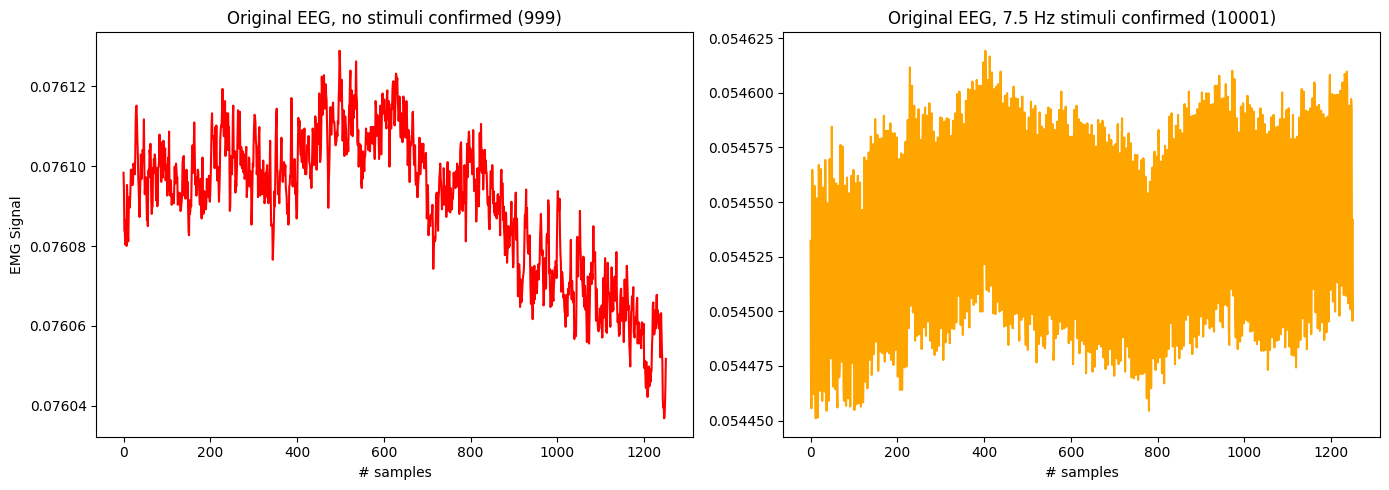

In [10]:
first_df = events_df.iloc[1, :-1]
second_df = events_df.iloc[40, :-1]

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(first_df, color='red')
axs[0].set_title('Original EEG, no stimuli confirmed (999)')
axs[0].set_xlabel('# samples')
axs[0].set_ylabel('EMG Signal')

axs[1].plot(second_df, color='orange')
axs[1].set_title('Original EEG, 7.5 Hz stimuli confirmed (10001)')
axs[1].set_xlabel('# samples')

plt.tight_layout()
plt.show()

# 3. Signal Preprocessing

### Preprocessing functions:

**1. Notch filter (to filter out 60 Hz powerline noise)**

**2. Bandpass filter (to select frequency of interest: 1 Hz - 40 Hz)**

**3. Wavelet Transform Denoising (to remove noise in time-frequency domain)**

4. Lowpass filter

5. Highpass filter



In [11]:
# band-pass filter
def bandpass_filter(data, lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# low-pass filter
def low_pass_filter(data, cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low')
    y = filtfilt(b, a, data)
    return y

# high-pass filter
def high_pass_filter(data, cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high')
    y = filtfilt(b, a, data)
    return y


# notch filter
def notch_filter(data, fs, f0, Q=30):
    w0 = f0 / (fs / 2)  # Normalized Frequency
    b, a = iirnotch(w0, Q)
    filtered_signal = filtfilt(b, a, data)
    return filtered_signal

# baseline correction
def apply_baseline_correction(data):
    corrected_data = data.copy()
    corrected_data = data - np.mean(data)
    return corrected_data


Wavelet Transform denoise function

In [12]:
def denoise_signal(signal, wavelet_name='db4', level=None, thresholding_strategy='soft', threshold_multiplier=1.0):

    coeff = pywt.wavedec(signal, wavelet_name, mode='per', level=level)

    sigma = np.median(np.abs(coeff[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(signal))) * threshold_multiplier

    coeff[1:] = [pywt.threshold(i, value=threshold, mode=thresholding_strategy) for i in coeff[1:]]

    recon_signal = pywt.waverec(coeff, wavelet_name, mode='per') # Reconstruct the signal using the modified coefficients

    return recon_signal

Dividing data into X (eeg segments) and y (labels) for machine learning.

In [13]:
X_data = events_df.iloc[:, :-1]
y_data = events_df.iloc[:, -1]

In [14]:
X_data

,0,1,2,3,4,5,6,7,8,9,...,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250
0,0.078397,0.078390,0.078389,0.078391,0.078386,0.078389,0.078393,0.078384,0.078382,0.078390,...,0.078351,0.078349,0.078351,0.078352,0.078349,0.078355,0.078330,0.078321,0.078328,0.078335
1,0.076098,0.076094,0.076084,0.076083,0.076080,0.076086,0.076086,0.076080,0.076095,0.076091,...,0.076054,0.076051,0.076041,0.076040,0.076040,0.076037,0.076037,0.076040,0.076045,0.076052
2,0.062841,0.062851,0.062904,0.062765,0.062853,0.062848,0.062889,0.062756,0.062878,0.062880,...,0.062763,0.062807,0.062808,0.062878,0.062717,0.062820,0.062808,0.062810,0.062721,0.062823
3,0.075959,0.076015,0.076169,0.075773,0.076023,0.076018,0.076143,0.075720,0.076084,0.076093,...,0.075823,0.075938,0.075940,0.076121,0.075678,0.075994,0.075987,0.076008,0.075723,0.076025
4,0.078154,0.078154,0.078153,0.078152,0.078154,0.078154,0.078156,0.078161,0.078154,0.078143,...,0.078198,0.078201,0.078208,0.078211,0.078203,0.078207,0.078219,0.078207,0.078201,0.078202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.060828,0.061092,0.061097,0.061039,0.060920,0.061090,0.061100,0.060926,0.061023,0.061052,...,0.061193,0.060928,0.061175,0.061197,0.061065,0.061048,0.061170,0.061190,0.060994,0.061118
496,0.066561,0.066563,0.066567,0.066563,0.066563,0.066556,0.066548,0.066549,0.066554,0.066553,...,0.066715,0.066703,0.066703,0.066706,0.066708,0.066707,0.066710,0.066707,0.066706,0.066714
497,0.063833,0.063834,0.063829,0.063824,0.063825,0.063826,0.063817,0.063813,0.063823,0.063825,...,0.063929,0.063924,0.063927,0.063928,0.063932,0.063926,0.063923,0.063917,0.063918,0.063925
498,0.048969,0.048999,0.048894,0.048963,0.048966,0.048995,0.048859,0.048967,0.048974,0.048972,...,0.049027,0.049046,0.049082,0.048961,0.049047,0.049051,0.049082,0.048954,0.049067,0.049076


## Preprocess dataframe

In [15]:
sampling_rate = 250

def preprocessdata(df):
    fs = sampling_rate
    f0 = 50    # Frequency to notch out
    processed_rows = []

    for i in range(len(df)):
        row = df.iloc[i].copy()

        #row.interpolate(method='linear', inplace=True)  # linearly interpolate to replace nan values

        #row = high_pass_filter(row, 10, fs)    # high pass filtering - remove low frequency drifts

        #row = apply_baseline_correction(row) # Apply baseline correction

        row = notch_filter(row, fs, f0, Q=30) # notch filtering - remove powerline noise

        row = bandpass_filter(row, 1, 40, fs, order = 2) # bandpass filtering - to preserve frequency of interest

        dwt_denoised = denoise_signal(row, wavelet_name='db4', level=4, threshold_multiplier=1.0)

        row = row[100:1000]  # cropping to center signal

        #row_df = pd.DataFrame([row])
        #row_df['target'] = df.iloc[i, -1]  # Add target column at the end

        processed_rows.append(row)

    # new_df = pd.concat(processed_rows, ignore_index=True)
    new_df = pd.DataFrame(processed_rows)

    return new_df

proc_X_data = preprocessdata(X_data)
proc_X_data

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,-5.706010e-08,-3.597832e-06,-0.000007,-9.102466e-06,-9.573747e-06,-8.462385e-06,-6.373543e-06,-4.073994e-06,-0.000002,-0.000001,...,1.221456e-06,-2.628138e-07,-7.628267e-07,-3.005618e-07,9.434723e-07,2.498212e-06,3.031034e-06,2.116034e-06,0.000002,0.000006
1,1.455678e-06,1.600946e-06,0.000003,4.393724e-06,5.622779e-06,4.974965e-06,2.296863e-06,-7.251641e-07,-0.000002,-0.000003,...,-5.285593e-06,-5.578556e-06,-3.816148e-06,-1.215006e-06,5.532131e-07,1.035670e-06,1.063495e-06,1.919638e-06,0.000005,0.000009
2,6.922474e-06,5.226736e-06,0.000007,3.774003e-06,-4.502733e-06,-7.027946e-06,-5.473651e-06,-8.375385e-06,-0.000012,-0.000009,...,8.576075e-06,5.056465e-06,7.552725e-06,7.346288e-06,1.018351e-06,-2.489035e-06,-1.894033e-06,-6.032839e-06,-0.000013,-0.000014
3,-1.732504e-05,-2.061212e-05,-0.000007,-5.544177e-06,-1.596849e-05,-9.757436e-06,6.638844e-06,5.849123e-06,-0.000002,0.000004,...,-1.158820e-05,-1.825574e-05,-7.331189e-06,-3.585655e-06,-1.554712e-05,-1.562329e-05,-6.083473e-07,7.712606e-07,-0.000009,-0.000002
4,-4.716788e-06,-4.945827e-06,-0.000004,-1.492868e-06,6.960218e-07,7.923031e-07,-1.234817e-06,-3.701082e-06,-0.000005,-0.000004,...,1.009515e-05,1.287407e-05,1.130352e-05,6.350663e-06,4.487331e-07,-3.925955e-06,-6.071361e-06,-7.004742e-06,-0.000007,-0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-3.978303e-06,-8.687119e-06,0.000002,1.124191e-05,3.990117e-06,-2.107912e-06,3.661303e-06,3.058544e-06,-0.000008,-0.000008,...,-7.261489e-07,-1.245446e-05,-7.568721e-06,5.012199e-06,2.163012e-06,-6.399165e-06,-1.527057e-06,3.609721e-06,-0.000005,-0.000009
496,2.655449e-06,2.567725e-06,0.000002,6.608946e-07,-4.908746e-07,-3.948651e-07,9.535368e-07,3.069691e-06,0.000006,0.000008,...,8.354698e-06,6.837616e-06,3.010945e-06,-2.326242e-06,-7.643768e-06,-1.137275e-05,-1.249301e-05,-1.095807e-05,-0.000008,-0.000004
497,-1.020611e-06,-7.716416e-07,-0.000001,-2.180708e-06,-2.171190e-06,-1.093466e-06,3.324964e-07,1.603310e-06,0.000003,0.000006,...,-2.937505e-06,-4.733677e-06,-6.380990e-06,-7.834381e-06,-8.885782e-06,-8.883556e-06,-7.850043e-06,-6.614621e-06,-0.000006,-0.000005
498,1.294390e-06,5.148507e-06,0.000006,1.094510e-06,-2.062487e-07,1.396350e-06,-1.365453e-06,-5.036435e-06,-0.000002,0.000005,...,-4.545618e-06,-1.727553e-06,3.774288e-07,-2.775874e-06,-3.962686e-06,-6.170086e-08,1.804301e-06,-4.975164e-07,-0.000001,-0.000001


Show visual comparison of before and after signal processing

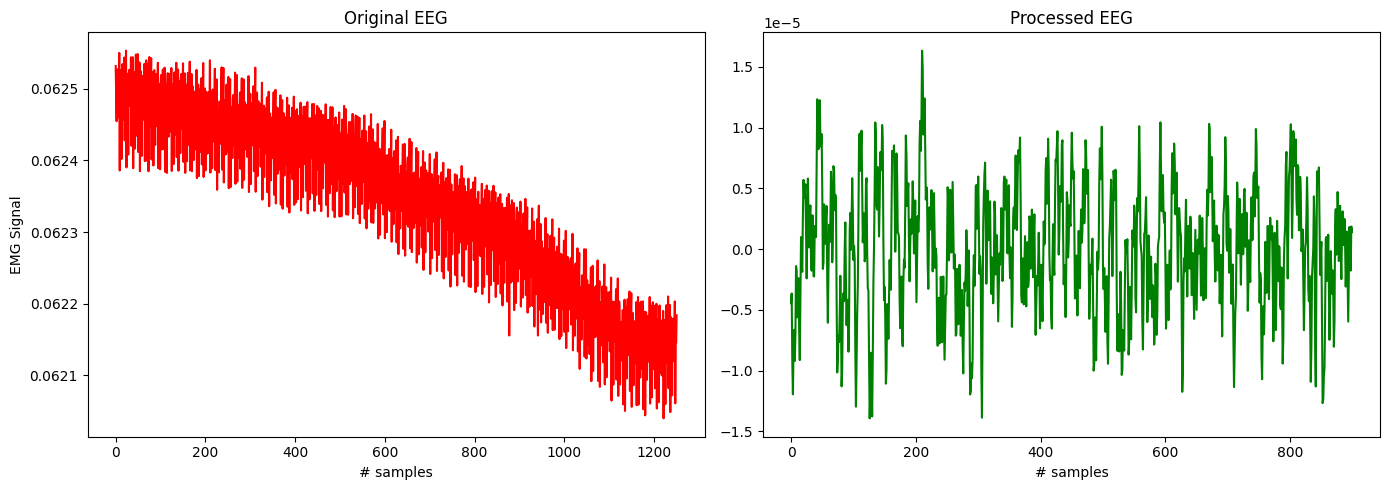

In [16]:
sample_df = X_data.iloc[10, :]
sample_processed_df = proc_X_data.iloc[10, :]

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(sample_df, color='red')
axs[0].set_title('Original EEG')
axs[0].set_xlabel('# samples')
axs[0].set_ylabel('EMG Signal')

axs[1].plot(sample_processed_df, color='green')
axs[1].set_title('Processed EEG')
axs[1].set_xlabel('# samples')

plt.tight_layout()
plt.show()

# 4. Feature Extraction

Defining Feature functions

In [17]:
# linear envelope
fs = sampling_rate

def extract_linear_envelope(data, fs):
    # Low-pass filter to extract Linear Envelope
    linear_envelope = low_pass_filter(data, cutoff=5, fs=fs)
    return linear_envelope

# Root Mean Square
def calculate_rms(data, window_size=60):
    rms = np.sqrt(np.convolve(data**2, np.ones(window_size)/window_size, mode='valid'))
    return rms

# Continous Wavelet transform
def cwt_wavelet_decompose(data, freq, waveletname):

    scales = np.arange(1, int(freq/10) + 1, 1)
    coefficients, frequencies = pywt.cwt(data, scales, waveletname, 1.0 / freq)

    decom_wavelets = pd.DataFrame(coefficients, index=np.round(frequencies, 2))

    return decom_wavelets

# Fast Fourier Transform
def fft_stat_features(signal):

    n = len(signal)
    freqs = np.fft.rfftfreq(n, d=1/fs)
    fft_values = np.abs(np.fft.rfft(signal))

    # Spectral power
    power = np.square(fft_values)

    # Mean frequency
    mean_frequency = np.sum(power * freqs) / np.sum(power)

    # Median frequency
    cumulative_power = np.cumsum(power)
    total_power = cumulative_power[-1]
    median_frequency = freqs[np.where(cumulative_power >= total_power / 2)[0][0]]

    # Peak frequency
    peak_frequency = freqs[np.argmax(power)]

    # Total spectral power
    total_spectral_power = np.sum(power)

    # Return all features as a dataframe
    features = [mean_frequency, median_frequency, peak_frequency, total_spectral_power]

    FFT_statistics = np.array(features).T

    return FFT_statistics


# Entropy
def shannon_entropy(data):
    hist, bin_edges = np.histogram(data, bins=10, density=True)
    hist = hist / hist.sum()
    hist = hist[hist > 0]
    return entropy(hist, base=2)



def dwt_stat_features(signal, wavelet='db4'):

    coeffs = pywt.wavedec(signal, wavelet, mode='per')
    concatenated_coeffs = np.concatenate(coeffs)

    mean_absolute_power = np.mean(np.abs(concatenated_coeffs))
    mean_average_value = np.mean(concatenated_coeffs)
    std_deviation = np.std(concatenated_coeffs)
    variance = np.var(concatenated_coeffs)

    features = [mean_absolute_power, mean_average_value, std_deviation, variance]
    dwt_statistics = np.array(features).T

    return dwt_statistics

### Feature Data 1: Linear Envelope + RMS

In [18]:
def feature1_env_rms(processed_data):

  processed_data2 = extract_linear_envelope(processed_data, fs)
  features1_data  = calculate_rms(processed_data2, window_size=60)

  return features1_data


### Feature Data 2: Continous Wavelet Transform (CWT)

In [19]:
def feature2_CWT(processed_data):

  processed_data2 = cwt_wavelet_decompose(processed_data, fs, 'morl')
  features2_data = processed_data2[0]


  return features2_data


### Feature Data 3: Fast Fourier Transform + Statistics

In [20]:
def feature3_FFTstat(processed_data):

  features3_data = fft_stat_features(processed_data)   # returns FFT stats - mean_frequency, median_frequency, peak_frequency, total_spectral_power

  return features3_data

### Feature Data 4: DWT + Statistics

In [21]:
def feature4_DWTstat(processed_data):

  features4_data = dwt_stat_features(processed_data) # return DWT stats - mean_absolute_power, mean_average_value, std_deviation, variance

  return features4_data

### Feature Data 5: FFT stats + Entropy

In [22]:
def feature5_FFT_entropy(processed_data):

  processed_data2 = fft_stat_features(processed_data)
  processed_data3 = shannon_entropy(processed_data)

  features5_data = np.append(processed_data2, processed_data3) # returns FFT stats AND entropy


  return features5_data

### Feature Data 6: All combined

In [23]:
def combine_features(row, fs):
    features_env_rms = feature1_env_rms(row)
    features_CWT = feature2_CWT(row)
    #features_FFTstat = feature3_FFTstat(row)
    feature_DWTstat = feature4_DWTstat(row)
    features_FFT_entropy = feature5_FFT_entropy(row)

    combined_features = np.hstack((features_env_rms, features_CWT, feature_DWTstat, features_FFT_entropy))
    return combined_features

### Creating 6 different feature dataframes based on feature 1, 2, 3, 4, 5 anf 6

In [24]:
feature_dataset_list_env_rms = []
feature_dataset_list_cwt = []
feature_dataset_list_FFTstat = []
feature_dataset_list_DWTstat = []
feature_dataset_list_FFT_entropy = []
feature_data_list_combine_features = []

for i in range(len(X_data)):

    row = X_data.iloc[i]

    feature_dataset_list_env_rms.append(pd.DataFrame([feature1_env_rms(row)]))
    feature_dataset_list_cwt.append(pd.DataFrame([feature2_CWT(row)]))
    feature_dataset_list_FFTstat.append(pd.DataFrame([feature3_FFTstat(row)]))
    feature_dataset_list_DWTstat.append(pd.DataFrame([feature4_DWTstat(row)]))
    feature_dataset_list_FFT_entropy.append(pd.DataFrame([feature5_FFT_entropy(row)]))
    feature_data_list_combine_features.append(pd.DataFrame([combine_features(row, fs)]))

# Concatenate all data frames in the list into a single DataFrame
feature_dataset_list_env_rms = pd.concat(feature_dataset_list_env_rms, ignore_index=True)
feature_dataset_list_cwt = pd.concat(feature_dataset_list_cwt, ignore_index=True)
feature_dataset_list_FFTstat = pd.concat(feature_dataset_list_FFTstat, ignore_index=True)
feature_dataset_list_DWTstat = pd.concat(feature_dataset_list_DWTstat, ignore_index=True)
feature_dataset_list_FFT_entropy = pd.concat(feature_dataset_list_FFT_entropy, ignore_index=True)
feature_data_list_combine_features = pd.concat(feature_data_list_combine_features, ignore_index=True)

In [64]:
feature_data_list_combine_features

,0,1,2,3,4,5,6,7,8,9,...,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225
0,0.078397,0.078397,0.078397,0.078397,0.078397,0.078397,0.078397,0.078397,0.078397,0.078397,...,0.000005,0.007074,0.007067,0.078863,0.006219,1.750864e-07,0.0,0.0,9620.034800,2.591641
1,0.076097,0.076097,0.076097,0.076097,0.076097,0.076097,0.076097,0.076097,0.076097,0.076097,...,0.000003,0.006864,0.006859,0.076538,0.005858,1.055605e-07,0.0,0.0,9061.111680,2.858446
2,0.062846,0.062846,0.062846,0.062846,0.062846,0.062846,0.062846,0.062847,0.062847,0.062847,...,0.000005,0.005701,0.005665,0.063208,0.003995,2.238982e-05,0.0,0.0,6179.841741,2.912652
3,0.075996,0.075997,0.075997,0.075998,0.075999,0.075999,0.076000,0.076000,0.076000,0.076000,...,-0.000010,0.006951,0.006850,0.076419,0.005840,1.330806e-04,0.0,0.0,9033.145235,2.867226
4,0.078143,0.078143,0.078143,0.078143,0.078143,0.078143,0.078143,0.078143,0.078143,0.078143,...,0.000009,0.007054,0.007048,0.078632,0.006183,1.803655e-07,0.0,0.0,9563.441249,2.792427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.061011,0.061015,0.061018,0.061021,0.061023,0.061025,0.061027,0.061029,0.061031,0.061032,...,-0.000024,0.005589,0.005509,0.061446,0.003776,1.317694e-04,0.0,0.0,5839.891595,3.001197
496,0.066555,0.066555,0.066555,0.066555,0.066555,0.066554,0.066554,0.066554,0.066554,0.066554,...,0.000007,0.006013,0.006008,0.067030,0.004493,3.349283e-07,0.0,0.0,6949.249473,3.160488
497,0.063826,0.063826,0.063825,0.063825,0.063825,0.063825,0.063825,0.063825,0.063825,0.063825,...,0.000002,0.005763,0.005759,0.064252,0.004128,2.370062e-07,0.0,0.0,6385.361702,3.070028
498,0.048949,0.048948,0.048948,0.048948,0.048948,0.048947,0.048947,0.048947,0.048947,0.048947,...,0.000001,0.004450,0.004418,0.049283,0.002429,3.008506e-05,0.0,0.0,3756.650768,2.955487


# 5. Feature Selection - for combined feature dataset

Reducing dimensionality of the combined feature dataset (because it has the highest no. of 1226 columns)

## PCA

In [26]:
from sklearn.decomposition import PCA

def apply_pca(features, n_components=5):
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(features)
    return principal_components


In [48]:
scaler = StandardScaler()

feature_data_list_combined_scaled = scaler.fit_transform(feature_data_list_combine_features)  # Standardize features by removing the mean and scaling to unit variance


In [49]:
n_components = 5  # taking 5 components
principal_components = apply_pca(feature_data_list_combined_scaled, n_components=n_components)
principal_df = pd.DataFrame(principal_components)
principal_df

,0,1,2,3,4
0,-49.867565,0.004381,0.275881,-0.057593,-1.877148
1,-43.840164,-0.050380,0.320426,0.090331,-0.377686
2,-9.414935,-0.170409,-0.188738,0.094876,-0.458220
3,-43.532108,0.003875,0.455408,0.316585,-0.345866
4,-49.247574,0.164643,0.376923,0.054143,-0.692028
...,...,...,...,...,...
495,-4.846949,0.656354,0.268996,-0.146674,0.010256
496,-19.257946,-0.309411,0.069750,0.247262,1.104928
497,-12.092998,-0.216646,-0.082291,0.112168,0.505386
498,26.537537,-0.533498,-0.722606,-0.236141,-0.592250


Therefore, our 7th feature dataset would be principal_df

# 6. Machine Learning and Deep Learning Classification

Classification of confirmed cases based on EEG segments (with and without features)

Classes: 10001 (7.5 Hz) and 999 (0 Hz)

Data used:

In [29]:
# feature_dataset_list_env_rms
# feature_dataset_list_cwt
# feature_dataset_list_FFTstat
# feature_dataset_list_DWTstat
# feature_dataset_list_FFT_entropy
# feature_data_list_combine_features
# principal_df

# y_data

In [30]:
y_data = y_data.replace({10001: 1, 999: 0})      # changing values for 10001 to 1 and 999 to 0 for machine learning
y_data

0      0
1      0
2      0
3      0
4      0
      ..
495    0
496    1
497    1
498    1
499    1
Name: target, Length: 500, dtype: int64

Define X and y here for the rest of the code to follow

In [65]:
X = feature_data_list_combine_features.values   # change here
y = y_data.values

In [66]:
# Split into training and test sets (90% training, 10% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [68]:
#Standardize the data - for non PCA data
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

print(X_train_val.shape)
print(X_test.shape)
print(y_train_val.shape)
print(y_test.shape)

(450, 1226)
(50, 1226)
(450,)
(50,)


## 6a. SVM (Linear Classifier)

(50,)
(50,)
Test Accuracy: 0.68


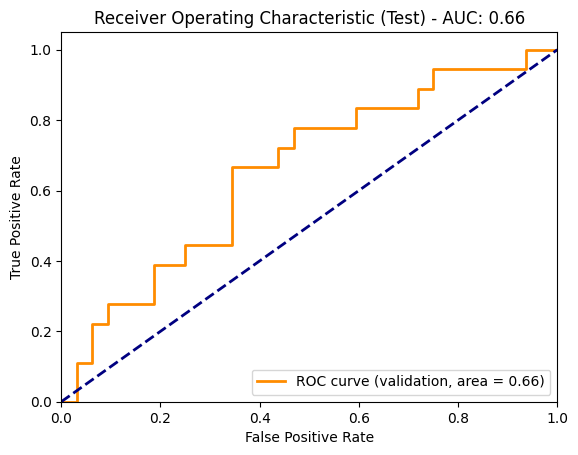

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.68      0.94      0.79        32
           1       0.67      0.22      0.33        18

    accuracy                           0.68        50
   macro avg       0.67      0.58      0.56        50
weighted avg       0.68      0.68      0.63        50



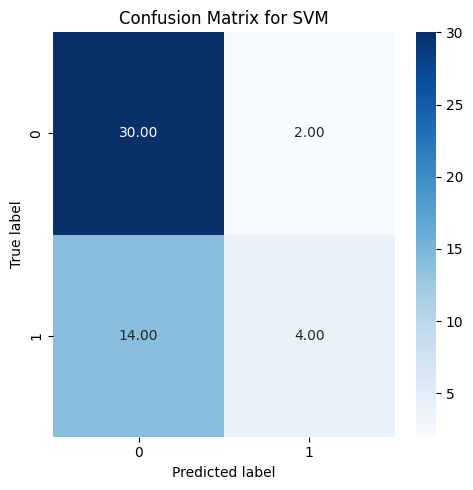

In [69]:
#SVM
LSVM = svm.SVC(kernel='linear', probability=True)
LSVM.fit(X_train_val, y_train_val)
y_test_pred = LSVM.predict(X_test)
print(y_test_pred.shape)
print(y_test.shape)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

# Generate ROC curve for test set
y_test_prob = LSVM.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()


plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (validation, area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (Test) - AUC: {roc_auc_test:.2f}')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix for test set
classes = [0, 1]
plot_confusion_matrix(y_test, y_test_pred, classes, title='Confusion Matrix for SVM')

# cm_test = confusion_matrix(y_test, y_test_pred)
# print("Confusion Matrix (Test):\n", cm_test)
print("Classification Report (Test):\n", classification_report(y_test, y_test_pred))


## Hyper Parameter Tuning of SVM

In [53]:
from sklearn.svm import SVC
# Define the hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1],  # Regularization strength
    'kernel': ['linear', 'rbf', 'poly'],  # Linear and RBF kernels
    'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf'
}

svm_model = SVC(probability=True, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_val, y_train_val)

print("Best Hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

y_test_prob = best_model.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (Test) - AUC: {roc_auc_test:.2f}')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix for test set
# cm_test = confusion_matrix(y_test, y_test_pred)
# print("Confusion Matrix (Test):\n", cm_test)

classes = [0, 1]
plot_confusion_matrix(y_test, y_test_pred, classes, title='Confusion Matrix for SVM')


print("Classification Report (Test):\n", classification_report(y_test, y_test_pred))

KeyboardInterrupt: 

## Deep learning classification

In [70]:
# further dividing X_train_val dataset to train and validation

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Standardize the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [71]:
def create_model(input_dim, layers, dropout_rate):
    class DynamicMLP(nn.Module):
        def __init__(self, input_dim, layers, dropout_rate):
            super(DynamicMLP, self).__init__()
            self.layers = nn.ModuleList()
            prev_dim = input_dim
            for layer_size in layers:
                self.layers.append(nn.Linear(prev_dim, layer_size))
                self.layers.append(nn.ReLU())
                self.layers.append(nn.Dropout(dropout_rate))
                prev_dim = layer_size
            self.layers.append(nn.Linear(prev_dim, 1))
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            for layer in self.layers:
                x = layer(x)
            x = self.sigmoid(x)
            return x

    return DynamicMLP(input_dim, layers, dropout_rate)


input_size = X_train_val.shape[1]
layers = [1024, 1024, 512, 512, 64, 64, 32]
dropout_rate = 0.15

model = create_model(input_size, layers, dropout_rate)

# Print the model's architecture
print(model)

DynamicMLP(
  (layers): ModuleList(
    (0): Linear(in_features=1226, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.15, inplace=False)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.15, inplace=False)
    (6): Linear(in_features=1024, out_features=512, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.15, inplace=False)
    (9): Linear(in_features=512, out_features=512, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.15, inplace=False)
    (12): Linear(in_features=512, out_features=64, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.15, inplace=False)
    (15): Linear(in_features=64, out_features=64, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.15, inplace=False)
    (18): Linear(in_features=64, out_features=32, bias=True)
    (19): ReLU()
    (20): Dropout(p=0.15, inplace=False)
    (21): Linear(in_features=32, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)


In [72]:
# parameters
epochs = 50
learning_rate = 0.001
batch = 32

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience= epochs // 10, verbose=True)

train_loader = DataLoader(train_dataset, batch_size= batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size= batch, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size= batch, shuffle=False)

best_val_loss = float('inf')
early_stopping_patience = epochs // 5
early_stopping_counter = 0
num_epochs = epochs

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    running_val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_val_loss += loss.item() * X_batch.size(0)

            preds = (outputs > 0.5).float()
            correct_predictions += (preds == y_batch).sum().item()
            total_predictions += y_batch.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_accuracy = correct_predictions / total_predictions
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

    scheduler.step(epoch_val_loss)

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping")
            break

model.load_state_dict(torch.load('best_model.pth'))



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6335, Val Loss: 0.6637, Val Accuracy: 0.6556
Epoch 2/50, Train Loss: 0.6220, Val Loss: 0.6772, Val Accuracy: 0.6556
Epoch 3/50, Train Loss: 0.6115, Val Loss: 0.6524, Val Accuracy: 0.6556
Epoch 4/50, Train Loss: 0.6074, Val Loss: 0.6799, Val Accuracy: 0.6556
Epoch 5/50, Train Loss: 0.5974, Val Loss: 0.6476, Val Accuracy: 0.6556
Epoch 6/50, Train Loss: 0.6049, Val Loss: 0.6727, Val Accuracy: 0.6556
Epoch 7/50, Train Loss: 0.6198, Val Loss: 0.6469, Val Accuracy: 0.6556
Epoch 8/50, Train Loss: 0.6023, Val Loss: 0.6617, Val Accuracy: 0.6556
Epoch 9/50, Train Loss: 0.6097, Val Loss: 0.6509, Val Accuracy: 0.6556
Epoch 10/50, Train Loss: 0.6093, Val Loss: 0.6449, Val Accuracy: 0.6556
Epoch 11/50, Train Loss: 0.5916, Val Loss: 0.6812, Val Accuracy: 0.6556
Epoch 12/50, Train Loss: 0.6179, Val Loss: 0.6392, Val Accuracy: 0.6556
Epoch 13/50, Train Loss: 0.6130, Val Loss: 0.6381, Val Accuracy: 0.6556
Epoch 14/50, Train Loss: 0.6049, Val Loss: 0.6519, Val Accuracy: 0.6556
E

<All keys matched successfully>

Test Accuracy: 0.64


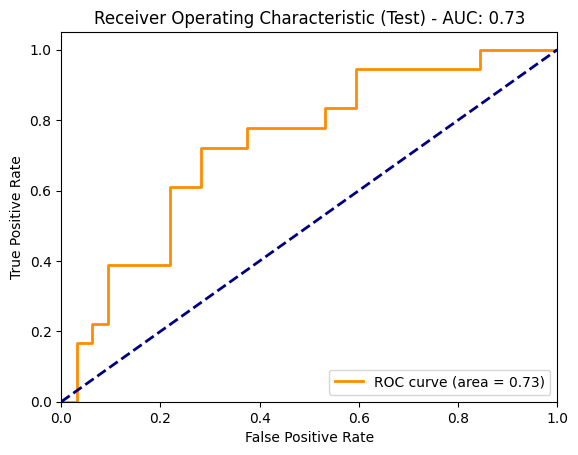

Confusion Matrix (Test):
 [[32  0]
 [18  0]]
Classification Report (Test):
               precision    recall  f1-score   support

         0.0       0.64      1.00      0.78        32
         1.0       0.00      0.00      0.00        18

    accuracy                           0.64        50
   macro avg       0.32      0.50      0.39        50
weighted avg       0.41      0.64      0.50        50



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


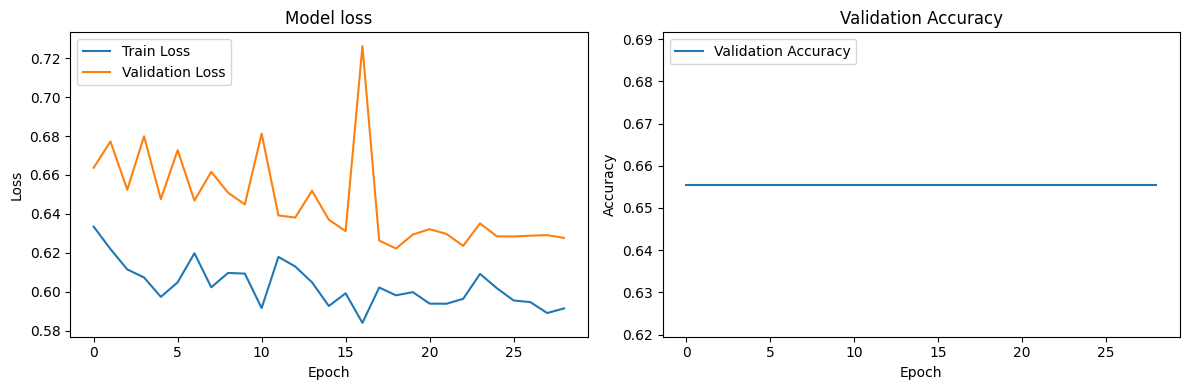

In [73]:
# Load the best model
model.eval()

# Evaluate the best model on the test set
y_test_pred_prob = []
y_test_true = []
test_loader = DataLoader(test_dataset, batch_size= batch, shuffle=False)  # Ensure test_loader here as well
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        y_test_pred_prob.append(outputs.numpy())
        y_test_true.append(y_batch.numpy())
y_test_pred_prob = np.vstack(y_test_pred_prob).ravel()
y_test_true = np.vstack(y_test_true).ravel()
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

test_accuracy = accuracy_score(y_test_true, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

# Generate ROC curve for test set
fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_pred_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (Test) - AUC: {roc_auc_test:.2f}')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix for test set
cm_test = confusion_matrix(y_test_true, y_test_pred)
print("Confusion Matrix (Test):\n", cm_test)
print("Classification Report (Test):\n", classification_report(y_test_true, y_test_pred))

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

### Hyper Parametertuning MLP

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6644, Val Loss: 0.6779, Val Accuracy: 0.6556
Epoch 2/50, Train Loss: 0.6450, Val Loss: 0.6503, Val Accuracy: 0.6556
Epoch 3/50, Train Loss: 0.6045, Val Loss: 0.6841, Val Accuracy: 0.6556
Epoch 4/50, Train Loss: 0.6494, Val Loss: 0.6834, Val Accuracy: 0.6444
Epoch 5/50, Train Loss: 0.6154, Val Loss: 0.6623, Val Accuracy: 0.6556
Epoch 6/50, Train Loss: 0.6109, Val Loss: 0.6594, Val Accuracy: 0.6556
Epoch 7/50, Train Loss: 0.6026, Val Loss: 0.6657, Val Accuracy: 0.6556
Epoch 8/50, Train Loss: 0.6051, Val Loss: 0.6501, Val Accuracy: 0.6556
Epoch 9/50, Train Loss: 0.5904, Val Loss: 0.6504, Val Accuracy: 0.6556
Epoch 10/50, Train Loss: 0.6057, Val Loss: 0.6539, Val Accuracy: 0.6556
Epoch 11/50, Train Loss: 0.5916, Val Loss: 0.6461, Val Accuracy: 0.6556
Epoch 12/50, Train Loss: 0.6123, Val Loss: 0.6623, Val Accuracy: 0.6556
Epoch 13/50, Train Loss: 0.6064, Val Loss: 0.6434, Val Accuracy: 0.6556
Epoch 14/50, Train Loss: 0.6162, Val Loss: 0.6447, Val Accuracy: 0.6556
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6597, Val Loss: 0.7439, Val Accuracy: 0.6556
Epoch 2/50, Train Loss: 0.6202, Val Loss: 0.6625, Val Accuracy: 0.6111
Epoch 3/50, Train Loss: 0.6413, Val Loss: 0.6618, Val Accuracy: 0.6111
Epoch 4/50, Train Loss: 0.6150, Val Loss: 0.7036, Val Accuracy: 0.6556
Epoch 5/50, Train Loss: 0.6363, Val Loss: 0.6779, Val Accuracy: 0.6556
Epoch 6/50, Train Loss: 0.6213, Val Loss: 0.6698, Val Accuracy: 0.6556
Epoch 7/50, Train Loss: 0.6102, Val Loss: 0.6572, Val Accuracy: 0.6556
Epoch 8/50, Train Loss: 0.6187, Val Loss: 0.6963, Val Accuracy: 0.6556
Epoch 9/50, Train Loss: 0.6235, Val Loss: 0.6638, Val Accuracy: 0.6556
Epoch 10/50, Train Loss: 0.5972, Val Loss: 0.6666, Val Accuracy: 0.6556
Epoch 11/50, Train Loss: 0.6126, Val Loss: 0.6636, Val Accuracy: 0.6556
Epoch 12/50, Train Loss: 0.6146, Val Loss: 0.6757, Val Accuracy: 0.6556
Epoch 13/50, Train Loss: 0.6181, Val Loss: 0.6532, Val Accuracy: 0.6556
Epoch 14/50, Train Loss: 0.6081, Val Loss: 0.6557, Val Accuracy: 0.6556
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 3/50, Train Loss: 0.6014, Val Loss: 0.6700, Val Accuracy: 0.6556
Epoch 4/50, Train Loss: 0.6015, Val Loss: 0.6586, Val Accuracy: 0.6556
Epoch 5/50, Train Loss: 0.5986, Val Loss: 0.6685, Val Accuracy: 0.6556
Epoch 6/50, Train Loss: 0.6006, Val Loss: 0.6722, Val Accuracy: 0.6556
Epoch 7/50, Train Loss: 0.6104, Val Loss: 0.6567, Val Accuracy: 0.6778
Epoch 8/50, Train Loss: 0.5951, Val Loss: 0.6515, Val Accuracy: 0.6556
Epoch 9/50, Train Loss: 0.5927, Val Loss: 0.6958, Val Accuracy: 0.6556
Epoch 10/50, Train Loss: 0.6046, Val Loss: 0.6470, Val Accuracy: 0.6556
Epoch 11/50, Train Loss: 0.6032, Val Loss: 0.6713, Val Accuracy: 0.6556
Epoch 12/50, Train Loss: 0.5940, Val Loss: 0.6581, Val Accuracy: 0.6556
Epoch 13/50, Train Loss: 0.5887, Val Loss: 0.6562, Val Accuracy: 0.6556
Epoch 14/50, Train Loss: 0.5983, Val Loss: 0.6603, Val Accuracy: 0.6556
Epoch 15/50, Train Loss: 0.5954, Val Loss: 0.6516, Val Accuracy: 0.6556
Epoch 16/50, Train Loss: 0.6023, Val Loss: 0.6415, Val Accuracy: 0.6556

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6516, Val Loss: 0.6528, Val Accuracy: 0.6667
Epoch 2/50, Train Loss: 0.6206, Val Loss: 0.6744, Val Accuracy: 0.6556
Epoch 3/50, Train Loss: 0.6165, Val Loss: 0.6508, Val Accuracy: 0.6444
Epoch 4/50, Train Loss: 0.6008, Val Loss: 0.6621, Val Accuracy: 0.6556
Epoch 5/50, Train Loss: 0.6139, Val Loss: 0.6566, Val Accuracy: 0.6556
Epoch 6/50, Train Loss: 0.6164, Val Loss: 0.6567, Val Accuracy: 0.6556
Epoch 7/50, Train Loss: 0.6088, Val Loss: 0.6493, Val Accuracy: 0.6556
Epoch 8/50, Train Loss: 0.6097, Val Loss: 0.6688, Val Accuracy: 0.6556
Epoch 9/50, Train Loss: 0.6191, Val Loss: 0.6502, Val Accuracy: 0.6556
Epoch 10/50, Train Loss: 0.6254, Val Loss: 0.6547, Val Accuracy: 0.6556
Epoch 11/50, Train Loss: 0.6074, Val Loss: 0.6513, Val Accuracy: 0.6556
Epoch 12/50, Train Loss: 0.6063, Val Loss: 0.6648, Val Accuracy: 0.6556
Epoch 13/50, Train Loss: 0.6056, Val Loss: 0.6539, Val Accuracy: 0.6556
Epoch 14/50, Train Loss: 0.6161, Val Loss: 0.6499, Val Accuracy: 0.6556
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6210, Val Loss: 0.7453, Val Accuracy: 0.6444
Epoch 2/50, Train Loss: 0.6354, Val Loss: 0.7122, Val Accuracy: 0.6444
Epoch 3/50, Train Loss: 0.6271, Val Loss: 0.6637, Val Accuracy: 0.6333
Epoch 4/50, Train Loss: 0.6037, Val Loss: 0.6922, Val Accuracy: 0.6111
Epoch 5/50, Train Loss: 0.6169, Val Loss: 0.6552, Val Accuracy: 0.6556
Epoch 6/50, Train Loss: 0.6225, Val Loss: 0.6728, Val Accuracy: 0.6556
Epoch 7/50, Train Loss: 0.6053, Val Loss: 0.6556, Val Accuracy: 0.6556
Epoch 8/50, Train Loss: 0.5995, Val Loss: 0.6811, Val Accuracy: 0.6556
Epoch 9/50, Train Loss: 0.6060, Val Loss: 0.6524, Val Accuracy: 0.6556
Epoch 10/50, Train Loss: 0.6082, Val Loss: 0.6603, Val Accuracy: 0.6556
Epoch 11/50, Train Loss: 0.6050, Val Loss: 0.6738, Val Accuracy: 0.6556
Epoch 12/50, Train Loss: 0.6051, Val Loss: 0.6540, Val Accuracy: 0.6556
Epoch 13/50, Train Loss: 0.6120, Val Loss: 0.6665, Val Accuracy: 0.6556
Epoch 14/50, Train Loss: 0.5978, Val Loss: 0.6533, Val Accuracy: 0.6556
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 2/50, Train Loss: 0.6495, Val Loss: 0.6730, Val Accuracy: 0.6556
Epoch 3/50, Train Loss: 0.6251, Val Loss: 0.6618, Val Accuracy: 0.6556
Epoch 4/50, Train Loss: 0.5972, Val Loss: 0.6628, Val Accuracy: 0.6556
Epoch 5/50, Train Loss: 0.6169, Val Loss: 0.6623, Val Accuracy: 0.6556
Epoch 6/50, Train Loss: 0.6103, Val Loss: 0.6508, Val Accuracy: 0.6556
Epoch 7/50, Train Loss: 0.6263, Val Loss: 0.6640, Val Accuracy: 0.6556
Epoch 8/50, Train Loss: 0.6023, Val Loss: 0.7092, Val Accuracy: 0.6556
Epoch 9/50, Train Loss: 0.6165, Val Loss: 0.6511, Val Accuracy: 0.6556
Epoch 10/50, Train Loss: 0.5948, Val Loss: 0.6720, Val Accuracy: 0.6556
Epoch 11/50, Train Loss: 0.5998, Val Loss: 0.6549, Val Accuracy: 0.6556
Epoch 12/50, Train Loss: 0.6055, Val Loss: 0.6536, Val Accuracy: 0.6556
Epoch 13/50, Train Loss: 0.5920, Val Loss: 0.6558, Val Accuracy: 0.6556
Epoch 14/50, Train Loss: 0.6070, Val Loss: 0.6537, Val Accuracy: 0.6556
Epoch 15/50, Train Loss: 0.5996, Val Loss: 0.6529, Val Accuracy: 0.6556


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6490, Val Loss: 0.6621, Val Accuracy: 0.6667
Epoch 2/100, Train Loss: 0.6500, Val Loss: 0.6527, Val Accuracy: 0.6556
Epoch 3/100, Train Loss: 0.6095, Val Loss: 0.6682, Val Accuracy: 0.6556
Epoch 4/100, Train Loss: 0.5986, Val Loss: 0.6513, Val Accuracy: 0.6222
Epoch 5/100, Train Loss: 0.6079, Val Loss: 0.6605, Val Accuracy: 0.6556
Epoch 6/100, Train Loss: 0.5989, Val Loss: 0.7293, Val Accuracy: 0.6556
Epoch 7/100, Train Loss: 0.6168, Val Loss: 0.6545, Val Accuracy: 0.6667
Epoch 8/100, Train Loss: 0.6045, Val Loss: 0.6837, Val Accuracy: 0.6556
Epoch 9/100, Train Loss: 0.5941, Val Loss: 0.6478, Val Accuracy: 0.6556
Epoch 10/100, Train Loss: 0.5948, Val Loss: 0.6600, Val Accuracy: 0.6556
Epoch 11/100, Train Loss: 0.6041, Val Loss: 0.6572, Val Accuracy: 0.6556
Epoch 12/100, Train Loss: 0.6008, Val Loss: 0.6469, Val Accuracy: 0.6556
Epoch 13/100, Train Loss: 0.5987, Val Loss: 0.6476, Val Accuracy: 0.6556
Epoch 14/100, Train Loss: 0.5979, Val Loss: 0.6464, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6986, Val Loss: 0.7363, Val Accuracy: 0.6556
Epoch 2/100, Train Loss: 0.6500, Val Loss: 0.6604, Val Accuracy: 0.6556
Epoch 3/100, Train Loss: 0.6197, Val Loss: 0.6785, Val Accuracy: 0.6556
Epoch 4/100, Train Loss: 0.6014, Val Loss: 0.6603, Val Accuracy: 0.6111
Epoch 5/100, Train Loss: 0.6257, Val Loss: 0.6863, Val Accuracy: 0.6556
Epoch 6/100, Train Loss: 0.6096, Val Loss: 0.6544, Val Accuracy: 0.6556
Epoch 7/100, Train Loss: 0.6198, Val Loss: 0.6728, Val Accuracy: 0.6556
Epoch 8/100, Train Loss: 0.5952, Val Loss: 0.6846, Val Accuracy: 0.6556
Epoch 9/100, Train Loss: 0.6143, Val Loss: 0.6640, Val Accuracy: 0.6556
Epoch 10/100, Train Loss: 0.6235, Val Loss: 0.6520, Val Accuracy: 0.6556
Epoch 11/100, Train Loss: 0.6030, Val Loss: 0.6553, Val Accuracy: 0.6556
Epoch 12/100, Train Loss: 0.6071, Val Loss: 0.6739, Val Accuracy: 0.6556
Epoch 13/100, Train Loss: 0.6480, Val Loss: 0.6496, Val Accuracy: 0.6556
Epoch 14/100, Train Loss: 0.6192, Val Loss: 0.6598, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 3/100, Train Loss: 0.6107, Val Loss: 0.6687, Val Accuracy: 0.6556
Epoch 4/100, Train Loss: 0.6102, Val Loss: 0.6561, Val Accuracy: 0.6556
Epoch 5/100, Train Loss: 0.6021, Val Loss: 0.6631, Val Accuracy: 0.6556
Epoch 6/100, Train Loss: 0.6023, Val Loss: 0.6518, Val Accuracy: 0.6556
Epoch 7/100, Train Loss: 0.6035, Val Loss: 0.6585, Val Accuracy: 0.6556
Epoch 8/100, Train Loss: 0.5937, Val Loss: 0.6551, Val Accuracy: 0.6556
Epoch 9/100, Train Loss: 0.6092, Val Loss: 0.6546, Val Accuracy: 0.6556
Epoch 10/100, Train Loss: 0.6048, Val Loss: 0.6634, Val Accuracy: 0.6556
Epoch 11/100, Train Loss: 0.5944, Val Loss: 0.6580, Val Accuracy: 0.6556
Epoch 12/100, Train Loss: 0.6020, Val Loss: 0.6477, Val Accuracy: 0.6556
Epoch 13/100, Train Loss: 0.5996, Val Loss: 0.6528, Val Accuracy: 0.6556
Epoch 14/100, Train Loss: 0.5941, Val Loss: 0.6512, Val Accuracy: 0.6556
Epoch 15/100, Train Loss: 0.6046, Val Loss: 0.6599, Val Accuracy: 0.6556
Epoch 16/100, Train Loss: 0.6078, Val Loss: 0.6524, Val Ac

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 3/100, Train Loss: 0.6121, Val Loss: 0.6913, Val Accuracy: 0.6444
Epoch 4/100, Train Loss: 0.6289, Val Loss: 0.6607, Val Accuracy: 0.6556
Epoch 5/100, Train Loss: 0.6035, Val Loss: 0.6537, Val Accuracy: 0.6556
Epoch 6/100, Train Loss: 0.6078, Val Loss: 0.6479, Val Accuracy: 0.6556
Epoch 7/100, Train Loss: 0.5985, Val Loss: 0.6726, Val Accuracy: 0.6556
Epoch 8/100, Train Loss: 0.6197, Val Loss: 0.6720, Val Accuracy: 0.6556
Epoch 9/100, Train Loss: 0.5977, Val Loss: 0.6652, Val Accuracy: 0.6556
Epoch 10/100, Train Loss: 0.5980, Val Loss: 0.6513, Val Accuracy: 0.6556
Epoch 11/100, Train Loss: 0.6064, Val Loss: 0.6585, Val Accuracy: 0.6556
Epoch 12/100, Train Loss: 0.6053, Val Loss: 0.6493, Val Accuracy: 0.6556
Epoch 13/100, Train Loss: 0.6085, Val Loss: 0.6574, Val Accuracy: 0.6556
Epoch 14/100, Train Loss: 0.6064, Val Loss: 0.6534, Val Accuracy: 0.6556
Epoch 15/100, Train Loss: 0.6012, Val Loss: 0.6473, Val Accuracy: 0.6556
Epoch 16/100, Train Loss: 0.6073, Val Loss: 0.6523, Val Ac

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6343, Val Loss: 0.6924, Val Accuracy: 0.6556
Epoch 2/100, Train Loss: 0.6197, Val Loss: 0.7638, Val Accuracy: 0.6556
Epoch 3/100, Train Loss: 0.6264, Val Loss: 0.6884, Val Accuracy: 0.6556
Epoch 4/100, Train Loss: 0.6345, Val Loss: 0.6566, Val Accuracy: 0.6556
Epoch 5/100, Train Loss: 0.6043, Val Loss: 0.6858, Val Accuracy: 0.6333
Epoch 6/100, Train Loss: 0.6145, Val Loss: 0.6610, Val Accuracy: 0.6556
Epoch 7/100, Train Loss: 0.6061, Val Loss: 0.6618, Val Accuracy: 0.6556
Epoch 8/100, Train Loss: 0.5933, Val Loss: 0.6616, Val Accuracy: 0.6556
Epoch 9/100, Train Loss: 0.6043, Val Loss: 0.6621, Val Accuracy: 0.6556
Epoch 10/100, Train Loss: 0.6078, Val Loss: 0.6531, Val Accuracy: 0.6556
Epoch 11/100, Train Loss: 0.6048, Val Loss: 0.6875, Val Accuracy: 0.6556
Epoch 12/100, Train Loss: 0.6146, Val Loss: 0.6544, Val Accuracy: 0.6556
Epoch 13/100, Train Loss: 0.6014, Val Loss: 0.6561, Val Accuracy: 0.6556
Epoch 14/100, Train Loss: 0.6179, Val Loss: 0.6558, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 2/100, Train Loss: 0.6220, Val Loss: 0.6924, Val Accuracy: 0.6556
Epoch 3/100, Train Loss: 0.6371, Val Loss: 0.6714, Val Accuracy: 0.6556
Epoch 4/100, Train Loss: 0.6297, Val Loss: 0.6781, Val Accuracy: 0.6333
Epoch 5/100, Train Loss: 0.5916, Val Loss: 0.6626, Val Accuracy: 0.6667
Epoch 6/100, Train Loss: 0.6183, Val Loss: 0.6623, Val Accuracy: 0.6556
Epoch 7/100, Train Loss: 0.6313, Val Loss: 0.6952, Val Accuracy: 0.6556
Epoch 8/100, Train Loss: 0.6103, Val Loss: 0.6597, Val Accuracy: 0.6556
Epoch 9/100, Train Loss: 0.6161, Val Loss: 0.6517, Val Accuracy: 0.6556
Epoch 10/100, Train Loss: 0.6111, Val Loss: 0.6679, Val Accuracy: 0.6556
Epoch 11/100, Train Loss: 0.6173, Val Loss: 0.6530, Val Accuracy: 0.6556
Epoch 12/100, Train Loss: 0.6321, Val Loss: 0.6707, Val Accuracy: 0.6556
Epoch 13/100, Train Loss: 0.6205, Val Loss: 0.6558, Val Accuracy: 0.6556
Epoch 14/100, Train Loss: 0.6112, Val Loss: 0.6646, Val Accuracy: 0.6556
Epoch 15/100, Train Loss: 0.6052, Val Loss: 0.6565, Val Acc

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6432, Val Loss: 0.8214, Val Accuracy: 0.6000
Epoch 2/50, Train Loss: 0.6298, Val Loss: 0.6630, Val Accuracy: 0.6111
Epoch 3/50, Train Loss: 0.6129, Val Loss: 0.7139, Val Accuracy: 0.6111
Epoch 4/50, Train Loss: 0.6211, Val Loss: 0.6625, Val Accuracy: 0.6222
Epoch 5/50, Train Loss: 0.6090, Val Loss: 0.6889, Val Accuracy: 0.6333
Epoch 6/50, Train Loss: 0.6044, Val Loss: 0.6569, Val Accuracy: 0.6111
Epoch 7/50, Train Loss: 0.6113, Val Loss: 0.6652, Val Accuracy: 0.6111
Epoch 8/50, Train Loss: 0.5978, Val Loss: 0.6624, Val Accuracy: 0.6222
Epoch 9/50, Train Loss: 0.6080, Val Loss: 0.6595, Val Accuracy: 0.6111
Epoch 10/50, Train Loss: 0.5991, Val Loss: 0.6585, Val Accuracy: 0.6222
Epoch 11/50, Train Loss: 0.6007, Val Loss: 0.6588, Val Accuracy: 0.6222
Epoch 12/50, Train Loss: 0.6009, Val Loss: 0.6521, Val Accuracy: 0.6333
Epoch 13/50, Train Loss: 0.5936, Val Loss: 0.6615, Val Accuracy: 0.6111
Epoch 14/50, Train Loss: 0.6011, Val Loss: 0.6543, Val Accuracy: 0.6556
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6530, Val Loss: 0.7441, Val Accuracy: 0.6556
Epoch 2/50, Train Loss: 0.6674, Val Loss: 0.7678, Val Accuracy: 0.6556
Epoch 3/50, Train Loss: 0.6703, Val Loss: 0.6554, Val Accuracy: 0.6444
Epoch 4/50, Train Loss: 0.6120, Val Loss: 0.6671, Val Accuracy: 0.6556
Epoch 5/50, Train Loss: 0.6027, Val Loss: 0.6943, Val Accuracy: 0.6556
Epoch 6/50, Train Loss: 0.5900, Val Loss: 0.6535, Val Accuracy: 0.6556
Epoch 7/50, Train Loss: 0.6037, Val Loss: 0.6641, Val Accuracy: 0.6556
Epoch 8/50, Train Loss: 0.6159, Val Loss: 0.6626, Val Accuracy: 0.6556
Epoch 9/50, Train Loss: 0.6035, Val Loss: 0.6559, Val Accuracy: 0.6556
Epoch 10/50, Train Loss: 0.6146, Val Loss: 0.6608, Val Accuracy: 0.6556
Epoch 11/50, Train Loss: 0.5969, Val Loss: 0.6646, Val Accuracy: 0.6556
Epoch 12/50, Train Loss: 0.6025, Val Loss: 0.6570, Val Accuracy: 0.6556
Epoch 13/50, Train Loss: 0.6004, Val Loss: 0.6583, Val Accuracy: 0.6556
Epoch 14/50, Train Loss: 0.5922, Val Loss: 0.6590, Val Accuracy: 0.6556
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 4/50, Train Loss: 0.6040, Val Loss: 0.6640, Val Accuracy: 0.6556
Epoch 5/50, Train Loss: 0.5973, Val Loss: 0.6574, Val Accuracy: 0.6556
Epoch 6/50, Train Loss: 0.5996, Val Loss: 0.6576, Val Accuracy: 0.6556
Epoch 7/50, Train Loss: 0.6000, Val Loss: 0.6591, Val Accuracy: 0.6556
Epoch 8/50, Train Loss: 0.5996, Val Loss: 0.6628, Val Accuracy: 0.6556
Epoch 9/50, Train Loss: 0.5971, Val Loss: 0.6612, Val Accuracy: 0.6556
Epoch 10/50, Train Loss: 0.6017, Val Loss: 0.6602, Val Accuracy: 0.6556
Epoch 11/50, Train Loss: 0.5951, Val Loss: 0.6590, Val Accuracy: 0.6556
Epoch 12/50, Train Loss: 0.6049, Val Loss: 0.6593, Val Accuracy: 0.6556
Early stopping
Params: {'learning_rate': 0.001, 'batch_size': 64, 'epochs': 50, 'layers': (256, 128, 64), 'dropout_rate': 0.1}, Test Accuracy: 0.64
Epoch 1/50, Train Loss: 0.6498, Val Loss: 0.7026, Val Accuracy: 0.6556
Epoch 2/50, Train Loss: 0.6127, Val Loss: 0.6570, Val Accuracy: 0.6556
Epoch 3/50, Train Loss: 0.6105, Val Loss: 0.6568, Val Accuracy: 0.65

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 4/50, Train Loss: 0.6095, Val Loss: 0.6724, Val Accuracy: 0.6556
Epoch 5/50, Train Loss: 0.6081, Val Loss: 0.6524, Val Accuracy: 0.6556
Epoch 6/50, Train Loss: 0.5955, Val Loss: 0.6617, Val Accuracy: 0.6556
Epoch 7/50, Train Loss: 0.5992, Val Loss: 0.6648, Val Accuracy: 0.6556
Epoch 8/50, Train Loss: 0.5989, Val Loss: 0.6569, Val Accuracy: 0.6556
Epoch 9/50, Train Loss: 0.6158, Val Loss: 0.6524, Val Accuracy: 0.6556
Epoch 10/50, Train Loss: 0.6061, Val Loss: 0.6553, Val Accuracy: 0.6556
Epoch 11/50, Train Loss: 0.6151, Val Loss: 0.6622, Val Accuracy: 0.6556
Epoch 12/50, Train Loss: 0.5963, Val Loss: 0.6598, Val Accuracy: 0.6556
Epoch 13/50, Train Loss: 0.5878, Val Loss: 0.6576, Val Accuracy: 0.6556
Epoch 14/50, Train Loss: 0.5897, Val Loss: 0.6557, Val Accuracy: 0.6556
Epoch 15/50, Train Loss: 0.5967, Val Loss: 0.6546, Val Accuracy: 0.6556
Epoch 16/50, Train Loss: 0.5883, Val Loss: 0.6542, Val Accuracy: 0.6556
Epoch 17/50, Train Loss: 0.6083, Val Loss: 0.6533, Val Accuracy: 0.655

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6473, Val Loss: 0.7116, Val Accuracy: 0.6111
Epoch 2/50, Train Loss: 0.6225, Val Loss: 0.6647, Val Accuracy: 0.6556
Epoch 3/50, Train Loss: 0.5990, Val Loss: 0.6581, Val Accuracy: 0.6556
Epoch 4/50, Train Loss: 0.5977, Val Loss: 0.6544, Val Accuracy: 0.6556
Epoch 5/50, Train Loss: 0.6149, Val Loss: 0.6659, Val Accuracy: 0.6556
Epoch 6/50, Train Loss: 0.6199, Val Loss: 0.6573, Val Accuracy: 0.6556
Epoch 7/50, Train Loss: 0.6031, Val Loss: 0.6478, Val Accuracy: 0.6556
Epoch 8/50, Train Loss: 0.6098, Val Loss: 0.6764, Val Accuracy: 0.6556
Epoch 9/50, Train Loss: 0.6004, Val Loss: 0.6490, Val Accuracy: 0.6556
Epoch 10/50, Train Loss: 0.6049, Val Loss: 0.6601, Val Accuracy: 0.6556
Epoch 11/50, Train Loss: 0.5961, Val Loss: 0.6618, Val Accuracy: 0.6556
Epoch 12/50, Train Loss: 0.6027, Val Loss: 0.6502, Val Accuracy: 0.6556
Epoch 13/50, Train Loss: 0.5953, Val Loss: 0.6483, Val Accuracy: 0.6556
Epoch 14/50, Train Loss: 0.5919, Val Loss: 0.6494, Val Accuracy: 0.6556
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 0.6093, Val Loss: 0.7920, Val Accuracy: 0.6333
Epoch 2/50, Train Loss: 0.6443, Val Loss: 0.7169, Val Accuracy: 0.6444
Epoch 3/50, Train Loss: 0.6230, Val Loss: 0.7093, Val Accuracy: 0.6111
Epoch 4/50, Train Loss: 0.6022, Val Loss: 0.7100, Val Accuracy: 0.6444
Epoch 5/50, Train Loss: 0.6254, Val Loss: 0.6710, Val Accuracy: 0.6444
Epoch 6/50, Train Loss: 0.6045, Val Loss: 0.6666, Val Accuracy: 0.6667
Epoch 7/50, Train Loss: 0.5973, Val Loss: 0.6694, Val Accuracy: 0.6333
Epoch 8/50, Train Loss: 0.5956, Val Loss: 0.6571, Val Accuracy: 0.6111
Epoch 9/50, Train Loss: 0.6084, Val Loss: 0.6633, Val Accuracy: 0.6444
Epoch 10/50, Train Loss: 0.6227, Val Loss: 0.6574, Val Accuracy: 0.6111
Epoch 11/50, Train Loss: 0.6067, Val Loss: 0.6773, Val Accuracy: 0.6556
Epoch 12/50, Train Loss: 0.6147, Val Loss: 0.6540, Val Accuracy: 0.6556
Epoch 13/50, Train Loss: 0.6075, Val Loss: 0.6805, Val Accuracy: 0.6556
Epoch 14/50, Train Loss: 0.6016, Val Loss: 0.6605, Val Accuracy: 0.6556
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6682, Val Loss: 0.6573, Val Accuracy: 0.6444
Epoch 2/100, Train Loss: 0.6182, Val Loss: 0.6548, Val Accuracy: 0.6556
Epoch 3/100, Train Loss: 0.6172, Val Loss: 0.6528, Val Accuracy: 0.6556
Epoch 4/100, Train Loss: 0.6157, Val Loss: 0.6711, Val Accuracy: 0.6556
Epoch 5/100, Train Loss: 0.5985, Val Loss: 0.6573, Val Accuracy: 0.6778
Epoch 6/100, Train Loss: 0.6005, Val Loss: 0.6960, Val Accuracy: 0.6556
Epoch 7/100, Train Loss: 0.6200, Val Loss: 0.6522, Val Accuracy: 0.6556
Epoch 8/100, Train Loss: 0.5912, Val Loss: 0.6658, Val Accuracy: 0.6556
Epoch 9/100, Train Loss: 0.5986, Val Loss: 0.6695, Val Accuracy: 0.6556
Epoch 10/100, Train Loss: 0.6066, Val Loss: 0.6517, Val Accuracy: 0.6556
Epoch 11/100, Train Loss: 0.6134, Val Loss: 0.6559, Val Accuracy: 0.6556
Epoch 12/100, Train Loss: 0.5933, Val Loss: 0.6519, Val Accuracy: 0.6556
Epoch 13/100, Train Loss: 0.5963, Val Loss: 0.6641, Val Accuracy: 0.6556
Epoch 14/100, Train Loss: 0.6006, Val Loss: 0.6503, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6768, Val Loss: 0.6704, Val Accuracy: 0.6556
Epoch 2/100, Train Loss: 0.6317, Val Loss: 0.6555, Val Accuracy: 0.6556
Epoch 3/100, Train Loss: 0.6216, Val Loss: 0.7076, Val Accuracy: 0.6556
Epoch 4/100, Train Loss: 0.6184, Val Loss: 0.6554, Val Accuracy: 0.6556
Epoch 5/100, Train Loss: 0.6076, Val Loss: 0.6632, Val Accuracy: 0.6556
Epoch 6/100, Train Loss: 0.6122, Val Loss: 0.6606, Val Accuracy: 0.6556
Epoch 7/100, Train Loss: 0.6031, Val Loss: 0.6541, Val Accuracy: 0.6556
Epoch 8/100, Train Loss: 0.6025, Val Loss: 0.6613, Val Accuracy: 0.6556
Epoch 9/100, Train Loss: 0.5976, Val Loss: 0.6654, Val Accuracy: 0.6556
Epoch 10/100, Train Loss: 0.5890, Val Loss: 0.6613, Val Accuracy: 0.6556
Epoch 11/100, Train Loss: 0.6055, Val Loss: 0.6607, Val Accuracy: 0.6556
Epoch 12/100, Train Loss: 0.5884, Val Loss: 0.6532, Val Accuracy: 0.6556
Epoch 13/100, Train Loss: 0.6102, Val Loss: 0.6514, Val Accuracy: 0.6556
Epoch 14/100, Train Loss: 0.6027, Val Loss: 0.6507, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 4/100, Train Loss: 0.6113, Val Loss: 0.6753, Val Accuracy: 0.6222
Epoch 5/100, Train Loss: 0.6022, Val Loss: 0.6583, Val Accuracy: 0.6444
Epoch 6/100, Train Loss: 0.5989, Val Loss: 0.6894, Val Accuracy: 0.6222
Epoch 7/100, Train Loss: 0.6093, Val Loss: 0.6584, Val Accuracy: 0.6111
Epoch 8/100, Train Loss: 0.6005, Val Loss: 0.6658, Val Accuracy: 0.6111
Epoch 9/100, Train Loss: 0.5995, Val Loss: 0.6601, Val Accuracy: 0.6222
Epoch 10/100, Train Loss: 0.5945, Val Loss: 0.6637, Val Accuracy: 0.6222
Epoch 11/100, Train Loss: 0.6071, Val Loss: 0.6585, Val Accuracy: 0.6111
Epoch 12/100, Train Loss: 0.6008, Val Loss: 0.6681, Val Accuracy: 0.6333
Epoch 13/100, Train Loss: 0.6022, Val Loss: 0.6565, Val Accuracy: 0.6222
Epoch 14/100, Train Loss: 0.5994, Val Loss: 0.6594, Val Accuracy: 0.6111
Epoch 15/100, Train Loss: 0.5892, Val Loss: 0.6638, Val Accuracy: 0.6111
Epoch 16/100, Train Loss: 0.6007, Val Loss: 0.6567, Val Accuracy: 0.6222
Epoch 17/100, Train Loss: 0.5928, Val Loss: 0.6645, Val A

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 4/100, Train Loss: 0.6282, Val Loss: 0.6580, Val Accuracy: 0.6556
Epoch 5/100, Train Loss: 0.5889, Val Loss: 0.6674, Val Accuracy: 0.6556
Epoch 6/100, Train Loss: 0.6038, Val Loss: 0.6758, Val Accuracy: 0.6556
Epoch 7/100, Train Loss: 0.6009, Val Loss: 0.6621, Val Accuracy: 0.6556
Epoch 8/100, Train Loss: 0.6059, Val Loss: 0.6539, Val Accuracy: 0.6556
Epoch 9/100, Train Loss: 0.6045, Val Loss: 0.6721, Val Accuracy: 0.6556
Epoch 10/100, Train Loss: 0.6015, Val Loss: 0.6611, Val Accuracy: 0.6556
Epoch 11/100, Train Loss: 0.5951, Val Loss: 0.6538, Val Accuracy: 0.6556
Epoch 12/100, Train Loss: 0.5953, Val Loss: 0.6570, Val Accuracy: 0.6556
Epoch 13/100, Train Loss: 0.6050, Val Loss: 0.6560, Val Accuracy: 0.6556
Epoch 14/100, Train Loss: 0.6016, Val Loss: 0.6532, Val Accuracy: 0.6556
Epoch 15/100, Train Loss: 0.6169, Val Loss: 0.6698, Val Accuracy: 0.6556
Epoch 16/100, Train Loss: 0.6097, Val Loss: 0.6568, Val Accuracy: 0.6556
Epoch 17/100, Train Loss: 0.6096, Val Loss: 0.6587, Val A

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 2/100, Train Loss: 0.6130, Val Loss: 0.7123, Val Accuracy: 0.6556
Epoch 3/100, Train Loss: 0.6188, Val Loss: 0.6511, Val Accuracy: 0.6444
Epoch 4/100, Train Loss: 0.6076, Val Loss: 0.6581, Val Accuracy: 0.6556
Epoch 5/100, Train Loss: 0.6058, Val Loss: 0.6553, Val Accuracy: 0.6556
Epoch 6/100, Train Loss: 0.6024, Val Loss: 0.6530, Val Accuracy: 0.6556
Epoch 7/100, Train Loss: 0.5942, Val Loss: 0.6566, Val Accuracy: 0.6556
Epoch 8/100, Train Loss: 0.5932, Val Loss: 0.6559, Val Accuracy: 0.6556
Epoch 9/100, Train Loss: 0.5966, Val Loss: 0.6598, Val Accuracy: 0.6556
Epoch 10/100, Train Loss: 0.6077, Val Loss: 0.6453, Val Accuracy: 0.6556
Epoch 11/100, Train Loss: 0.5944, Val Loss: 0.6646, Val Accuracy: 0.6556
Epoch 12/100, Train Loss: 0.5955, Val Loss: 0.6528, Val Accuracy: 0.6556
Epoch 13/100, Train Loss: 0.5939, Val Loss: 0.6583, Val Accuracy: 0.6556
Epoch 14/100, Train Loss: 0.5975, Val Loss: 0.6632, Val Accuracy: 0.6556
Epoch 15/100, Train Loss: 0.6013, Val Loss: 0.6471, Val Acc

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6470, Val Loss: 0.6533, Val Accuracy: 0.6556
Epoch 2/100, Train Loss: 0.6365, Val Loss: 0.6562, Val Accuracy: 0.6556
Epoch 3/100, Train Loss: 0.6097, Val Loss: 0.6610, Val Accuracy: 0.6556
Epoch 4/100, Train Loss: 0.6091, Val Loss: 0.6586, Val Accuracy: 0.6556
Epoch 5/100, Train Loss: 0.6018, Val Loss: 0.6630, Val Accuracy: 0.6556
Epoch 6/100, Train Loss: 0.5981, Val Loss: 0.6616, Val Accuracy: 0.6556
Epoch 7/100, Train Loss: 0.6142, Val Loss: 0.6662, Val Accuracy: 0.6556
Epoch 8/100, Train Loss: 0.6072, Val Loss: 0.6674, Val Accuracy: 0.6667
Epoch 9/100, Train Loss: 0.5930, Val Loss: 0.6624, Val Accuracy: 0.6556
Epoch 10/100, Train Loss: 0.6093, Val Loss: 0.6615, Val Accuracy: 0.6556
Epoch 11/100, Train Loss: 0.6108, Val Loss: 0.6604, Val Accuracy: 0.6556
Epoch 12/100, Train Loss: 0.6105, Val Loss: 0.6541, Val Accuracy: 0.6556
Epoch 13/100, Train Loss: 0.5998, Val Loss: 0.6522, Val Accuracy: 0.6556
Epoch 14/100, Train Loss: 0.5985, Val Loss: 0.6521, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 19.8804, Val Loss: 12.8699, Val Accuracy: 0.6556
Epoch 2/50, Train Loss: 11.1070, Val Loss: 11.4642, Val Accuracy: 0.6333
Epoch 3/50, Train Loss: 10.9282, Val Loss: 16.5640, Val Accuracy: 0.6556
Epoch 4/50, Train Loss: 11.3256, Val Loss: 11.7937, Val Accuracy: 0.6444
Epoch 5/50, Train Loss: 11.1997, Val Loss: 11.4615, Val Accuracy: 0.6444
Epoch 6/50, Train Loss: 11.1482, Val Loss: 11.4669, Val Accuracy: 0.6111
Epoch 7/50, Train Loss: 11.1469, Val Loss: 11.4810, Val Accuracy: 0.6222
Epoch 8/50, Train Loss: 11.1403, Val Loss: 11.4655, Val Accuracy: 0.6111
Epoch 9/50, Train Loss: 11.1396, Val Loss: 11.4654, Val Accuracy: 0.6556
Epoch 10/50, Train Loss: 11.1391, Val Loss: 11.4644, Val Accuracy: 0.6556
Epoch 11/50, Train Loss: 11.1598, Val Loss: 11.4638, Val Accuracy: 0.6556
Epoch 12/50, Train Loss: 11.1391, Val Loss: 11.4638, Val Accuracy: 0.6556
Epoch 13/50, Train Loss: 11.1389, Val Loss: 11.4638, Val Accuracy: 0.6556
Epoch 14/50, Train Loss: 11.1387, Val Loss: 11.

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 30.5767, Val Loss: 38.8889, Val Accuracy: 0.6111
Epoch 2/50, Train Loss: 49.7498, Val Loss: 65.5556, Val Accuracy: 0.3444
Epoch 3/50, Train Loss: 68.0556, Val Loss: 65.5556, Val Accuracy: 0.3444
Epoch 4/50, Train Loss: 68.0556, Val Loss: 65.5556, Val Accuracy: 0.3444
Epoch 5/50, Train Loss: 68.0556, Val Loss: 65.5556, Val Accuracy: 0.3444
Epoch 6/50, Train Loss: 68.0556, Val Loss: 65.5556, Val Accuracy: 0.3444
Epoch 7/50, Train Loss: 68.0556, Val Loss: 65.5556, Val Accuracy: 0.3444
Epoch 8/50, Train Loss: 68.0556, Val Loss: 65.5556, Val Accuracy: 0.3444
Epoch 9/50, Train Loss: 68.0556, Val Loss: 65.5556, Val Accuracy: 0.3444
Epoch 10/50, Train Loss: 68.0556, Val Loss: 65.5556, Val Accuracy: 0.3444
Epoch 11/50, Train Loss: 68.0556, Val Loss: 65.5556, Val Accuracy: 0.3444
Early stopping
Params: {'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'layers': (1024, 512, 256), 'dropout_rate': 0.2}, Test Accuracy: 0.64
Epoch 1/50, Train Loss: 1.0651, Val Loss: 0.74

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 2/50, Train Loss: 0.6991, Val Loss: 0.6980, Val Accuracy: 0.6556
Epoch 3/50, Train Loss: 0.6093, Val Loss: 0.6556, Val Accuracy: 0.6556
Epoch 4/50, Train Loss: 0.5970, Val Loss: 0.6526, Val Accuracy: 0.6556
Epoch 5/50, Train Loss: 0.6182, Val Loss: 0.6609, Val Accuracy: 0.6556
Epoch 6/50, Train Loss: 0.6054, Val Loss: 0.6477, Val Accuracy: 0.6556
Epoch 7/50, Train Loss: 0.6285, Val Loss: 0.6582, Val Accuracy: 0.6556
Epoch 8/50, Train Loss: 0.6298, Val Loss: 0.6521, Val Accuracy: 0.6556
Epoch 9/50, Train Loss: 0.5921, Val Loss: 0.6826, Val Accuracy: 0.6556
Epoch 10/50, Train Loss: 0.6487, Val Loss: 0.6941, Val Accuracy: 0.6556
Epoch 11/50, Train Loss: 0.6105, Val Loss: 0.6425, Val Accuracy: 0.6556
Epoch 12/50, Train Loss: 0.6129, Val Loss: 0.6403, Val Accuracy: 0.6556
Epoch 13/50, Train Loss: 0.6118, Val Loss: 0.6362, Val Accuracy: 0.6556
Epoch 14/50, Train Loss: 0.6039, Val Loss: 0.6401, Val Accuracy: 0.6556
Epoch 15/50, Train Loss: 0.6026, Val Loss: 0.6419, Val Accuracy: 0.6556


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 3/50, Train Loss: 0.6531, Val Loss: 0.6583, Val Accuracy: 0.6222
Epoch 4/50, Train Loss: 0.6530, Val Loss: 0.6781, Val Accuracy: 0.6444
Epoch 5/50, Train Loss: 0.6483, Val Loss: 0.6588, Val Accuracy: 0.6556
Epoch 6/50, Train Loss: 0.6085, Val Loss: 0.6506, Val Accuracy: 0.6556
Epoch 7/50, Train Loss: 0.6602, Val Loss: 0.6460, Val Accuracy: 0.6556
Epoch 8/50, Train Loss: 0.6204, Val Loss: 0.6431, Val Accuracy: 0.6556
Epoch 9/50, Train Loss: 0.6198, Val Loss: 0.6496, Val Accuracy: 0.6556
Epoch 10/50, Train Loss: 0.6223, Val Loss: 0.6414, Val Accuracy: 0.6556
Epoch 11/50, Train Loss: 0.6078, Val Loss: 0.6477, Val Accuracy: 0.6556
Epoch 12/50, Train Loss: 0.6118, Val Loss: 0.6399, Val Accuracy: 0.6556
Epoch 13/50, Train Loss: 0.6118, Val Loss: 0.6446, Val Accuracy: 0.6556
Epoch 14/50, Train Loss: 0.6039, Val Loss: 0.6382, Val Accuracy: 0.6333
Epoch 15/50, Train Loss: 0.6047, Val Loss: 0.6408, Val Accuracy: 0.6556
Epoch 16/50, Train Loss: 0.6200, Val Loss: 0.6375, Val Accuracy: 0.6556

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 2/50, Train Loss: 0.8615, Val Loss: 0.7927, Val Accuracy: 0.6667
Epoch 3/50, Train Loss: 0.6673, Val Loss: 0.6634, Val Accuracy: 0.6556
Epoch 4/50, Train Loss: 0.6162, Val Loss: 0.6813, Val Accuracy: 0.6556
Epoch 5/50, Train Loss: 0.6188, Val Loss: 0.6493, Val Accuracy: 0.6556
Epoch 6/50, Train Loss: 0.6032, Val Loss: 0.6528, Val Accuracy: 0.6556
Epoch 7/50, Train Loss: 0.6159, Val Loss: 0.6560, Val Accuracy: 0.6556
Epoch 8/50, Train Loss: 0.6150, Val Loss: 0.6664, Val Accuracy: 0.6556
Epoch 9/50, Train Loss: 0.6317, Val Loss: 0.6469, Val Accuracy: 0.6556
Epoch 10/50, Train Loss: 0.6001, Val Loss: 0.7052, Val Accuracy: 0.6222
Epoch 11/50, Train Loss: 0.6112, Val Loss: 0.6441, Val Accuracy: 0.6556
Epoch 12/50, Train Loss: 0.5960, Val Loss: 0.6736, Val Accuracy: 0.6556
Epoch 13/50, Train Loss: 0.6229, Val Loss: 0.6423, Val Accuracy: 0.6556
Epoch 14/50, Train Loss: 0.6059, Val Loss: 0.6673, Val Accuracy: 0.6556
Epoch 15/50, Train Loss: 0.6146, Val Loss: 0.6429, Val Accuracy: 0.6444


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 2/50, Train Loss: 0.6750, Val Loss: 0.6540, Val Accuracy: 0.6556
Epoch 3/50, Train Loss: 0.6384, Val Loss: 0.6612, Val Accuracy: 0.6556
Epoch 4/50, Train Loss: 0.6394, Val Loss: 0.6476, Val Accuracy: 0.6556
Epoch 5/50, Train Loss: 0.6534, Val Loss: 0.7673, Val Accuracy: 0.6556
Epoch 6/50, Train Loss: 0.6427, Val Loss: 0.7281, Val Accuracy: 0.6556
Epoch 7/50, Train Loss: 0.6695, Val Loss: 0.6441, Val Accuracy: 0.6556
Epoch 8/50, Train Loss: 0.6389, Val Loss: 0.6918, Val Accuracy: 0.6556
Epoch 9/50, Train Loss: 0.6499, Val Loss: 0.6671, Val Accuracy: 0.6556
Epoch 10/50, Train Loss: 0.6624, Val Loss: 0.6861, Val Accuracy: 0.5556
Epoch 11/50, Train Loss: 0.6452, Val Loss: 0.6401, Val Accuracy: 0.6556
Epoch 12/50, Train Loss: 0.6194, Val Loss: 0.6427, Val Accuracy: 0.6556
Epoch 13/50, Train Loss: 0.6372, Val Loss: 0.6386, Val Accuracy: 0.6556
Epoch 14/50, Train Loss: 0.6192, Val Loss: 0.6420, Val Accuracy: 0.6556
Epoch 15/50, Train Loss: 0.6092, Val Loss: 0.6382, Val Accuracy: 0.6556


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 29.0458, Val Loss: 34.4444, Val Accuracy: 0.6556
Epoch 2/100, Train Loss: 31.9444, Val Loss: 34.4444, Val Accuracy: 0.6556
Epoch 3/100, Train Loss: 31.9444, Val Loss: 34.4444, Val Accuracy: 0.6556
Epoch 4/100, Train Loss: 31.9444, Val Loss: 34.4444, Val Accuracy: 0.6556
Epoch 5/100, Train Loss: 31.9444, Val Loss: 34.4444, Val Accuracy: 0.6556
Epoch 6/100, Train Loss: 31.9444, Val Loss: 34.4444, Val Accuracy: 0.6556
Epoch 7/100, Train Loss: 31.9444, Val Loss: 34.4444, Val Accuracy: 0.6556
Epoch 8/100, Train Loss: 31.9444, Val Loss: 34.4444, Val Accuracy: 0.6556
Epoch 9/100, Train Loss: 31.9444, Val Loss: 34.4444, Val Accuracy: 0.6556
Epoch 10/100, Train Loss: 31.9444, Val Loss: 34.4444, Val Accuracy: 0.6556
Epoch 11/100, Train Loss: 31.9444, Val Loss: 34.4444, Val Accuracy: 0.6556
Epoch 12/100, Train Loss: 31.9444, Val Loss: 34.4444, Val Accuracy: 0.6556
Epoch 13/100, Train Loss: 31.9444, Val Loss: 34.4444, Val Accuracy: 0.6556
Epoch 14/100, Train Loss: 31.9444,

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 58.4094, Val Loss: 65.5556, Val Accuracy: 0.3444
Epoch 2/100, Train Loss: 47.4782, Val Loss: 34.4444, Val Accuracy: 0.6556
Epoch 3/100, Train Loss: 31.9444, Val Loss: 34.4444, Val Accuracy: 0.6556
Epoch 4/100, Train Loss: 31.9444, Val Loss: 34.4444, Val Accuracy: 0.6556
Epoch 5/100, Train Loss: 31.9444, Val Loss: 34.4444, Val Accuracy: 0.6556
Epoch 6/100, Train Loss: 31.9444, Val Loss: 34.4444, Val Accuracy: 0.6556
Epoch 7/100, Train Loss: 31.9444, Val Loss: 34.4444, Val Accuracy: 0.6556
Epoch 8/100, Train Loss: 31.9444, Val Loss: 34.4444, Val Accuracy: 0.6556
Epoch 9/100, Train Loss: 31.9444, Val Loss: 34.4444, Val Accuracy: 0.6556
Epoch 10/100, Train Loss: 31.9444, Val Loss: 34.4444, Val Accuracy: 0.6556
Epoch 11/100, Train Loss: 31.9444, Val Loss: 34.4444, Val Accuracy: 0.6556
Epoch 12/100, Train Loss: 31.9444, Val Loss: 34.4444, Val Accuracy: 0.6556
Epoch 13/100, Train Loss: 31.9444, Val Loss: 34.4444, Val Accuracy: 0.6556
Epoch 14/100, Train Loss: 31.9444,

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 3/100, Train Loss: 0.6159, Val Loss: 0.6546, Val Accuracy: 0.6556
Epoch 4/100, Train Loss: 0.6131, Val Loss: 0.6808, Val Accuracy: 0.6556
Epoch 5/100, Train Loss: 0.6261, Val Loss: 0.6726, Val Accuracy: 0.6556
Epoch 6/100, Train Loss: 0.6084, Val Loss: 0.6441, Val Accuracy: 0.6556
Epoch 7/100, Train Loss: 0.6050, Val Loss: 0.6488, Val Accuracy: 0.6556
Epoch 8/100, Train Loss: 0.6096, Val Loss: 0.6572, Val Accuracy: 0.6556
Epoch 9/100, Train Loss: 0.6061, Val Loss: 0.6421, Val Accuracy: 0.6556
Epoch 10/100, Train Loss: 0.6074, Val Loss: 0.6434, Val Accuracy: 0.6556
Epoch 11/100, Train Loss: 0.6039, Val Loss: 0.6435, Val Accuracy: 0.6556
Epoch 12/100, Train Loss: 0.5970, Val Loss: 0.6601, Val Accuracy: 0.6556
Epoch 13/100, Train Loss: 0.6061, Val Loss: 0.6386, Val Accuracy: 0.6556
Epoch 14/100, Train Loss: 0.6078, Val Loss: 0.6395, Val Accuracy: 0.6556
Epoch 15/100, Train Loss: 0.6364, Val Loss: 0.6525, Val Accuracy: 0.6556
Epoch 16/100, Train Loss: 0.6354, Val Loss: 0.6440, Val Ac

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 1.0356, Val Loss: 0.7097, Val Accuracy: 0.6222
Epoch 2/100, Train Loss: 0.6611, Val Loss: 0.6704, Val Accuracy: 0.6556
Epoch 3/100, Train Loss: 0.6320, Val Loss: 0.6537, Val Accuracy: 0.6556
Epoch 4/100, Train Loss: 0.6575, Val Loss: 0.6495, Val Accuracy: 0.6556
Epoch 5/100, Train Loss: 0.6522, Val Loss: 0.6507, Val Accuracy: 0.6556
Epoch 6/100, Train Loss: 0.6301, Val Loss: 0.7336, Val Accuracy: 0.6556
Epoch 7/100, Train Loss: 0.6619, Val Loss: 0.6483, Val Accuracy: 0.6556
Epoch 8/100, Train Loss: 0.6036, Val Loss: 0.6648, Val Accuracy: 0.6556
Epoch 9/100, Train Loss: 0.6139, Val Loss: 0.6459, Val Accuracy: 0.6556
Epoch 10/100, Train Loss: 0.6160, Val Loss: 0.6521, Val Accuracy: 0.6556
Epoch 11/100, Train Loss: 0.6248, Val Loss: 0.6389, Val Accuracy: 0.6556
Epoch 12/100, Train Loss: 0.6035, Val Loss: 0.6470, Val Accuracy: 0.6556
Epoch 13/100, Train Loss: 0.5963, Val Loss: 0.6395, Val Accuracy: 0.6556
Epoch 14/100, Train Loss: 0.6178, Val Loss: 0.6448, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 8.0484, Val Loss: 0.8785, Val Accuracy: 0.6444
Epoch 2/100, Train Loss: 0.6668, Val Loss: 0.6965, Val Accuracy: 0.6556
Epoch 3/100, Train Loss: 0.6617, Val Loss: 0.7355, Val Accuracy: 0.6556
Epoch 4/100, Train Loss: 0.6501, Val Loss: 0.7313, Val Accuracy: 0.6556
Epoch 5/100, Train Loss: 0.6426, Val Loss: 0.6537, Val Accuracy: 0.6556
Epoch 6/100, Train Loss: 0.6251, Val Loss: 0.6644, Val Accuracy: 0.6556
Epoch 7/100, Train Loss: 0.6455, Val Loss: 0.6585, Val Accuracy: 0.6556
Epoch 8/100, Train Loss: 0.6046, Val Loss: 0.6484, Val Accuracy: 0.6556
Epoch 9/100, Train Loss: 0.6056, Val Loss: 0.7388, Val Accuracy: 0.6556
Epoch 10/100, Train Loss: 0.6375, Val Loss: 0.6495, Val Accuracy: 0.6556
Epoch 11/100, Train Loss: 0.6239, Val Loss: 0.6807, Val Accuracy: 0.6556
Epoch 12/100, Train Loss: 0.6079, Val Loss: 0.6539, Val Accuracy: 0.6556
Epoch 13/100, Train Loss: 0.5998, Val Loss: 0.6466, Val Accuracy: 0.6556
Epoch 14/100, Train Loss: 0.5984, Val Loss: 0.7112, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 3.7062, Val Loss: 0.7983, Val Accuracy: 0.3778
Epoch 2/100, Train Loss: 0.6515, Val Loss: 0.6549, Val Accuracy: 0.6556
Epoch 3/100, Train Loss: 0.6447, Val Loss: 0.6787, Val Accuracy: 0.6333
Epoch 4/100, Train Loss: 0.6372, Val Loss: 0.6713, Val Accuracy: 0.6556
Epoch 5/100, Train Loss: 0.6155, Val Loss: 0.6675, Val Accuracy: 0.6556
Epoch 6/100, Train Loss: 0.6446, Val Loss: 0.6525, Val Accuracy: 0.6556
Epoch 7/100, Train Loss: 0.6257, Val Loss: 0.6618, Val Accuracy: 0.6556
Epoch 8/100, Train Loss: 0.6269, Val Loss: 0.6864, Val Accuracy: 0.6556
Epoch 9/100, Train Loss: 0.6541, Val Loss: 0.6469, Val Accuracy: 0.6556
Epoch 10/100, Train Loss: 0.6302, Val Loss: 0.6616, Val Accuracy: 0.6556
Epoch 11/100, Train Loss: 0.6472, Val Loss: 0.6563, Val Accuracy: 0.6556
Epoch 12/100, Train Loss: 0.6430, Val Loss: 0.6507, Val Accuracy: 0.6556
Epoch 13/100, Train Loss: 0.6380, Val Loss: 0.6468, Val Accuracy: 0.6556
Epoch 14/100, Train Loss: 0.6337, Val Loss: 0.6448, Val Accu

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 24.7462, Val Loss: 22.0350, Val Accuracy: 0.6556
Epoch 2/50, Train Loss: 10.8851, Val Loss: 1.3271, Val Accuracy: 0.6111
Epoch 3/50, Train Loss: 1.2230, Val Loss: 0.7866, Val Accuracy: 0.3444
Epoch 4/50, Train Loss: 0.8640, Val Loss: 0.7252, Val Accuracy: 0.6556
Epoch 5/50, Train Loss: 0.7100, Val Loss: 0.8264, Val Accuracy: 0.6556
Epoch 6/50, Train Loss: 0.6787, Val Loss: 0.7417, Val Accuracy: 0.3778
Epoch 7/50, Train Loss: 0.6280, Val Loss: 0.6966, Val Accuracy: 0.6556
Epoch 8/50, Train Loss: 0.6377, Val Loss: 0.6642, Val Accuracy: 0.6556
Epoch 9/50, Train Loss: 0.6241, Val Loss: 0.7104, Val Accuracy: 0.6556
Epoch 10/50, Train Loss: 0.6203, Val Loss: 0.6680, Val Accuracy: 0.6222
Epoch 11/50, Train Loss: 0.6474, Val Loss: 0.6682, Val Accuracy: 0.6556
Epoch 12/50, Train Loss: 0.6793, Val Loss: 0.6526, Val Accuracy: 0.6556
Epoch 13/50, Train Loss: 0.6560, Val Loss: 0.6520, Val Accuracy: 0.6556
Epoch 14/50, Train Loss: 0.6119, Val Loss: 0.6531, Val Accuracy: 0.655

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 19.4572, Val Loss: 12.7714, Val Accuracy: 0.6556
Epoch 2/50, Train Loss: 11.3843, Val Loss: 11.4540, Val Accuracy: 0.6889
Epoch 3/50, Train Loss: 11.1755, Val Loss: 11.4632, Val Accuracy: 0.6333
Epoch 4/50, Train Loss: 11.1828, Val Loss: 11.4864, Val Accuracy: 0.6111
Epoch 5/50, Train Loss: 11.1799, Val Loss: 11.4661, Val Accuracy: 0.6333
Epoch 6/50, Train Loss: 11.1516, Val Loss: 11.4610, Val Accuracy: 0.6222
Epoch 7/50, Train Loss: 11.1576, Val Loss: 11.4714, Val Accuracy: 0.6111
Epoch 8/50, Train Loss: 11.1479, Val Loss: 11.4651, Val Accuracy: 0.6222
Epoch 9/50, Train Loss: 11.0859, Val Loss: 11.4654, Val Accuracy: 0.6000
Epoch 10/50, Train Loss: 11.1352, Val Loss: 11.4663, Val Accuracy: 0.6111
Epoch 11/50, Train Loss: 11.1320, Val Loss: 11.4671, Val Accuracy: 0.6111
Epoch 12/50, Train Loss: 11.1434, Val Loss: 11.4667, Val Accuracy: 0.6111
Early stopping
Params: {'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'layers': (1024, 512, 256), 'dropout_rate'

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 4/50, Train Loss: 0.6051, Val Loss: 0.6475, Val Accuracy: 0.6556
Epoch 5/50, Train Loss: 0.6268, Val Loss: 0.6491, Val Accuracy: 0.6556
Epoch 6/50, Train Loss: 0.6144, Val Loss: 0.6464, Val Accuracy: 0.6556
Epoch 7/50, Train Loss: 0.6087, Val Loss: 0.6580, Val Accuracy: 0.6556
Epoch 8/50, Train Loss: 0.6122, Val Loss: 0.6462, Val Accuracy: 0.6556
Epoch 9/50, Train Loss: 0.6100, Val Loss: 0.6455, Val Accuracy: 0.6556
Epoch 10/50, Train Loss: 0.6071, Val Loss: 0.6432, Val Accuracy: 0.6556
Epoch 11/50, Train Loss: 0.6135, Val Loss: 0.6533, Val Accuracy: 0.6556
Epoch 12/50, Train Loss: 0.6071, Val Loss: 0.6431, Val Accuracy: 0.6556
Epoch 13/50, Train Loss: 0.6110, Val Loss: 0.6435, Val Accuracy: 0.6556
Epoch 14/50, Train Loss: 0.5946, Val Loss: 0.6516, Val Accuracy: 0.6556
Epoch 15/50, Train Loss: 0.6090, Val Loss: 0.6406, Val Accuracy: 0.6556
Epoch 16/50, Train Loss: 0.6030, Val Loss: 0.6493, Val Accuracy: 0.6556
Epoch 17/50, Train Loss: 0.6028, Val Loss: 0.6424, Val Accuracy: 0.655

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 2/50, Train Loss: 0.7482, Val Loss: 0.6704, Val Accuracy: 0.6111
Epoch 3/50, Train Loss: 0.6498, Val Loss: 0.6813, Val Accuracy: 0.6556
Epoch 4/50, Train Loss: 0.6460, Val Loss: 0.6590, Val Accuracy: 0.6556
Epoch 5/50, Train Loss: 0.6228, Val Loss: 0.6624, Val Accuracy: 0.6556
Epoch 6/50, Train Loss: 0.6124, Val Loss: 0.6499, Val Accuracy: 0.6556
Epoch 7/50, Train Loss: 0.6739, Val Loss: 0.6614, Val Accuracy: 0.6556
Epoch 8/50, Train Loss: 0.5971, Val Loss: 0.6536, Val Accuracy: 0.6556
Epoch 9/50, Train Loss: 0.6152, Val Loss: 0.6464, Val Accuracy: 0.6556
Epoch 10/50, Train Loss: 0.5988, Val Loss: 0.6480, Val Accuracy: 0.6556
Epoch 11/50, Train Loss: 0.6086, Val Loss: 0.6439, Val Accuracy: 0.6556
Epoch 12/50, Train Loss: 0.6082, Val Loss: 0.6434, Val Accuracy: 0.6556
Epoch 13/50, Train Loss: 0.5951, Val Loss: 0.6486, Val Accuracy: 0.6556
Epoch 14/50, Train Loss: 0.6089, Val Loss: 0.6410, Val Accuracy: 0.6556
Epoch 15/50, Train Loss: 0.6071, Val Loss: 0.6500, Val Accuracy: 0.6556


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 12.1210, Val Loss: 0.7892, Val Accuracy: 0.6556
Epoch 2/50, Train Loss: 0.7465, Val Loss: 0.7242, Val Accuracy: 0.6556
Epoch 3/50, Train Loss: 0.6751, Val Loss: 0.7172, Val Accuracy: 0.6556
Epoch 4/50, Train Loss: 0.6412, Val Loss: 0.6899, Val Accuracy: 0.6556
Epoch 5/50, Train Loss: 0.6049, Val Loss: 0.6581, Val Accuracy: 0.6556
Epoch 6/50, Train Loss: 0.6086, Val Loss: 0.6560, Val Accuracy: 0.6556
Epoch 7/50, Train Loss: 0.6139, Val Loss: 0.6645, Val Accuracy: 0.6333
Epoch 8/50, Train Loss: 0.5971, Val Loss: 0.6529, Val Accuracy: 0.6444
Epoch 9/50, Train Loss: 0.5946, Val Loss: 0.6517, Val Accuracy: 0.6556
Epoch 10/50, Train Loss: 0.6099, Val Loss: 0.6609, Val Accuracy: 0.6556
Epoch 11/50, Train Loss: 0.6068, Val Loss: 0.6552, Val Accuracy: 0.6556
Epoch 12/50, Train Loss: 0.6230, Val Loss: 0.6513, Val Accuracy: 0.6556
Epoch 13/50, Train Loss: 0.6077, Val Loss: 0.6583, Val Accuracy: 0.6556
Epoch 14/50, Train Loss: 0.5975, Val Loss: 0.6463, Val Accuracy: 0.6556


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50, Train Loss: 5.0531, Val Loss: 0.7086, Val Accuracy: 0.6556
Epoch 2/50, Train Loss: 0.7503, Val Loss: 0.6560, Val Accuracy: 0.6444
Epoch 3/50, Train Loss: 0.6758, Val Loss: 0.6586, Val Accuracy: 0.6556
Epoch 4/50, Train Loss: 0.6364, Val Loss: 0.6551, Val Accuracy: 0.6556
Epoch 5/50, Train Loss: 0.6309, Val Loss: 0.6565, Val Accuracy: 0.6556
Epoch 6/50, Train Loss: 0.6198, Val Loss: 0.6522, Val Accuracy: 0.6556
Epoch 7/50, Train Loss: 0.6603, Val Loss: 0.6626, Val Accuracy: 0.6556
Epoch 8/50, Train Loss: 0.6286, Val Loss: 0.6517, Val Accuracy: 0.6556
Epoch 9/50, Train Loss: 0.6269, Val Loss: 0.6494, Val Accuracy: 0.6556
Epoch 10/50, Train Loss: 0.6124, Val Loss: 0.6473, Val Accuracy: 0.6556
Epoch 11/50, Train Loss: 0.6197, Val Loss: 0.6448, Val Accuracy: 0.6556
Epoch 12/50, Train Loss: 0.6187, Val Loss: 0.6497, Val Accuracy: 0.6556
Epoch 13/50, Train Loss: 0.6198, Val Loss: 0.6623, Val Accuracy: 0.6556
Epoch 14/50, Train Loss: 0.6056, Val Loss: 0.6406, Val Accuracy: 0.6556
E

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 19.8662, Val Loss: 48.8450, Val Accuracy: 0.3889
Epoch 2/100, Train Loss: 47.7461, Val Loss: 4.6196, Val Accuracy: 0.6556
Epoch 3/100, Train Loss: 6.1522, Val Loss: 2.7860, Val Accuracy: 0.6778
Epoch 4/100, Train Loss: 1.8944, Val Loss: 1.3466, Val Accuracy: 0.3889
Epoch 5/100, Train Loss: 0.8584, Val Loss: 1.1105, Val Accuracy: 0.6556
Epoch 6/100, Train Loss: 0.7784, Val Loss: 0.6664, Val Accuracy: 0.6556
Epoch 7/100, Train Loss: 0.6468, Val Loss: 0.6596, Val Accuracy: 0.6556
Epoch 8/100, Train Loss: 0.6361, Val Loss: 0.6582, Val Accuracy: 0.6556
Epoch 9/100, Train Loss: 0.6100, Val Loss: 0.7076, Val Accuracy: 0.6556
Epoch 10/100, Train Loss: 0.6340, Val Loss: 0.6678, Val Accuracy: 0.6556
Epoch 11/100, Train Loss: 0.6801, Val Loss: 0.6644, Val Accuracy: 0.6556
Epoch 12/100, Train Loss: 0.6238, Val Loss: 0.7326, Val Accuracy: 0.6556
Epoch 13/100, Train Loss: 0.6574, Val Loss: 0.6481, Val Accuracy: 0.6556
Epoch 14/100, Train Loss: 0.6120, Val Loss: 0.6537, Val A

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 23.3003, Val Loss: 10.2887, Val Accuracy: 0.6556
Epoch 2/100, Train Loss: 25.4653, Val Loss: 35.9771, Val Accuracy: 0.6111
Epoch 3/100, Train Loss: 32.2812, Val Loss: 37.8923, Val Accuracy: 0.6111
Epoch 4/100, Train Loss: 33.3815, Val Loss: 38.8889, Val Accuracy: 0.6111
Epoch 5/100, Train Loss: 33.3969, Val Loss: 38.8889, Val Accuracy: 0.6111
Epoch 6/100, Train Loss: 33.8889, Val Loss: 38.8889, Val Accuracy: 0.6111
Epoch 7/100, Train Loss: 32.8857, Val Loss: 30.3809, Val Accuracy: 0.6111
Epoch 8/100, Train Loss: 29.8209, Val Loss: 37.9305, Val Accuracy: 0.6111
Epoch 9/100, Train Loss: 33.3894, Val Loss: 38.8889, Val Accuracy: 0.6111
Epoch 10/100, Train Loss: 33.4081, Val Loss: 38.8889, Val Accuracy: 0.6111
Epoch 11/100, Train Loss: 33.3973, Val Loss: 37.9472, Val Accuracy: 0.6111
Epoch 12/100, Train Loss: 31.3959, Val Loss: 31.7521, Val Accuracy: 0.6556
Epoch 13/100, Train Loss: 27.9113, Val Loss: 29.4508, Val Accuracy: 0.6444
Epoch 14/100, Train Loss: 28.6096,

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 4/100, Train Loss: 0.6595, Val Loss: 0.6683, Val Accuracy: 0.6556
Epoch 5/100, Train Loss: 0.6372, Val Loss: 0.6575, Val Accuracy: 0.6556
Epoch 6/100, Train Loss: 0.6073, Val Loss: 0.6545, Val Accuracy: 0.6556
Epoch 7/100, Train Loss: 0.6315, Val Loss: 0.6483, Val Accuracy: 0.6556
Epoch 8/100, Train Loss: 0.6198, Val Loss: 0.6577, Val Accuracy: 0.6556
Epoch 9/100, Train Loss: 0.6060, Val Loss: 0.6502, Val Accuracy: 0.6556
Epoch 10/100, Train Loss: 0.5960, Val Loss: 0.6917, Val Accuracy: 0.6556
Epoch 11/100, Train Loss: 0.6091, Val Loss: 0.6493, Val Accuracy: 0.6556
Epoch 12/100, Train Loss: 0.6019, Val Loss: 0.6778, Val Accuracy: 0.6556
Epoch 13/100, Train Loss: 0.6148, Val Loss: 0.6452, Val Accuracy: 0.6556
Epoch 14/100, Train Loss: 0.6079, Val Loss: 0.6453, Val Accuracy: 0.6556
Epoch 15/100, Train Loss: 0.5827, Val Loss: 0.6938, Val Accuracy: 0.6556
Epoch 16/100, Train Loss: 0.6150, Val Loss: 0.6432, Val Accuracy: 0.6556
Epoch 17/100, Train Loss: 0.6062, Val Loss: 0.6443, Val A

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 3/100, Train Loss: 0.6945, Val Loss: 0.6489, Val Accuracy: 0.6556
Epoch 4/100, Train Loss: 0.6252, Val Loss: 0.6507, Val Accuracy: 0.6556
Epoch 5/100, Train Loss: 0.6217, Val Loss: 0.6481, Val Accuracy: 0.6556
Epoch 6/100, Train Loss: 0.6248, Val Loss: 0.6563, Val Accuracy: 0.6556
Epoch 7/100, Train Loss: 0.6361, Val Loss: 0.6520, Val Accuracy: 0.6556
Epoch 8/100, Train Loss: 0.5985, Val Loss: 0.6532, Val Accuracy: 0.6556
Epoch 9/100, Train Loss: 0.6020, Val Loss: 0.6458, Val Accuracy: 0.6556
Epoch 10/100, Train Loss: 0.6082, Val Loss: 0.6447, Val Accuracy: 0.6556
Epoch 11/100, Train Loss: 0.6185, Val Loss: 0.6490, Val Accuracy: 0.6556
Epoch 12/100, Train Loss: 0.6324, Val Loss: 0.6475, Val Accuracy: 0.6556
Epoch 13/100, Train Loss: 0.6245, Val Loss: 0.6419, Val Accuracy: 0.6556
Epoch 14/100, Train Loss: 0.6011, Val Loss: 0.6409, Val Accuracy: 0.6556
Epoch 15/100, Train Loss: 0.5978, Val Loss: 0.6428, Val Accuracy: 0.6556
Epoch 16/100, Train Loss: 0.6276, Val Loss: 0.6409, Val Ac

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 2/100, Train Loss: 0.8281, Val Loss: 0.7928, Val Accuracy: 0.4111
Epoch 3/100, Train Loss: 0.8087, Val Loss: 0.7257, Val Accuracy: 0.5000
Epoch 4/100, Train Loss: 0.6560, Val Loss: 0.6876, Val Accuracy: 0.6556
Epoch 5/100, Train Loss: 0.5962, Val Loss: 0.6491, Val Accuracy: 0.6556
Epoch 6/100, Train Loss: 0.6099, Val Loss: 0.6697, Val Accuracy: 0.6556
Epoch 7/100, Train Loss: 0.6306, Val Loss: 0.6504, Val Accuracy: 0.6556
Epoch 8/100, Train Loss: 0.6257, Val Loss: 0.6564, Val Accuracy: 0.6556
Epoch 9/100, Train Loss: 0.6011, Val Loss: 0.6993, Val Accuracy: 0.6556
Epoch 10/100, Train Loss: 0.6389, Val Loss: 0.6453, Val Accuracy: 0.6556
Epoch 11/100, Train Loss: 0.6370, Val Loss: 0.6668, Val Accuracy: 0.6556
Epoch 12/100, Train Loss: 0.6240, Val Loss: 0.6462, Val Accuracy: 0.6556
Epoch 13/100, Train Loss: 0.6096, Val Loss: 0.6573, Val Accuracy: 0.6556
Epoch 14/100, Train Loss: 0.5983, Val Loss: 0.6481, Val Accuracy: 0.6556
Epoch 15/100, Train Loss: 0.5964, Val Loss: 0.6454, Val Acc

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 3/100, Train Loss: 0.7517, Val Loss: 0.7370, Val Accuracy: 0.6444
Epoch 4/100, Train Loss: 0.6189, Val Loss: 0.6571, Val Accuracy: 0.6333
Epoch 5/100, Train Loss: 0.6270, Val Loss: 0.6569, Val Accuracy: 0.6222
Epoch 6/100, Train Loss: 0.6116, Val Loss: 0.6668, Val Accuracy: 0.6556
Epoch 7/100, Train Loss: 0.6176, Val Loss: 0.6554, Val Accuracy: 0.6556
Epoch 8/100, Train Loss: 0.6044, Val Loss: 0.6646, Val Accuracy: 0.6556
Epoch 9/100, Train Loss: 0.6171, Val Loss: 0.6526, Val Accuracy: 0.6556
Epoch 10/100, Train Loss: 0.6067, Val Loss: 0.6564, Val Accuracy: 0.6556
Epoch 11/100, Train Loss: 0.6075, Val Loss: 0.6571, Val Accuracy: 0.6556
Epoch 12/100, Train Loss: 0.6068, Val Loss: 0.6490, Val Accuracy: 0.6556
Epoch 13/100, Train Loss: 0.5957, Val Loss: 0.6656, Val Accuracy: 0.6556
Epoch 14/100, Train Loss: 0.6220, Val Loss: 0.6475, Val Accuracy: 0.6556
Epoch 15/100, Train Loss: 0.6085, Val Loss: 0.6472, Val Accuracy: 0.6556
Epoch 16/100, Train Loss: 0.6431, Val Loss: 0.6508, Val Ac

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.6680, Val Loss: 0.6645, Val Accuracy: 0.6111
Epoch 2/100, Train Loss: 0.5999, Val Loss: 0.6647, Val Accuracy: 0.6444
Epoch 3/100, Train Loss: 0.6189, Val Loss: 0.7066, Val Accuracy: 0.6556
Epoch 4/100, Train Loss: 0.6119, Val Loss: 0.7029, Val Accuracy: 0.6444
Epoch 5/100, Train Loss: 0.6382, Val Loss: 0.6612, Val Accuracy: 0.6556
Epoch 6/100, Train Loss: 0.6021, Val Loss: 0.6573, Val Accuracy: 0.6556
Epoch 7/100, Train Loss: 0.6169, Val Loss: 0.6829, Val Accuracy: 0.6556
Epoch 8/100, Train Loss: 0.6279, Val Loss: 0.6524, Val Accuracy: 0.6444
Epoch 9/100, Train Loss: 0.6197, Val Loss: 0.6509, Val Accuracy: 0.6556
Epoch 10/100, Train Loss: 0.6141, Val Loss: 0.6656, Val Accuracy: 0.6556
Epoch 11/100, Train Loss: 0.6143, Val Loss: 0.6525, Val Accuracy: 0.6556
Epoch 12/100, Train Loss: 0.6061, Val Loss: 0.6590, Val Accuracy: 0.6556
Epoch 13/100, Train Loss: 0.6081, Val Loss: 0.6569, Val Accuracy: 0.6556
Epoch 14/100, Train Loss: 0.6013, Val Loss: 0.6640, Val Accu

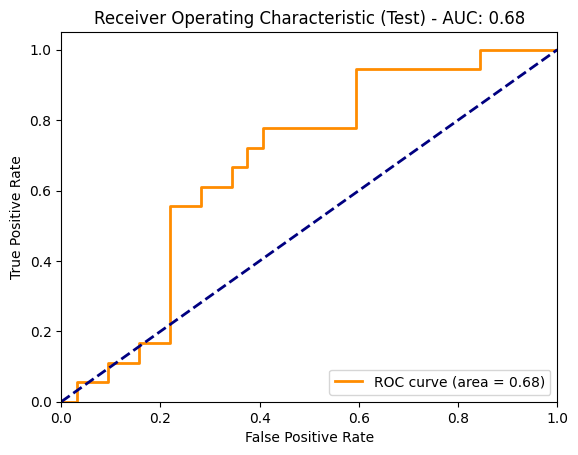

Confusion Matrix (Test):
 [[31  1]
 [17  1]]
Classification Report (Test):
               precision    recall  f1-score   support

         0.0       0.65      0.97      0.78        32
         1.0       0.50      0.06      0.10        18

    accuracy                           0.64        50
   macro avg       0.57      0.51      0.44        50
weighted avg       0.59      0.64      0.53        50



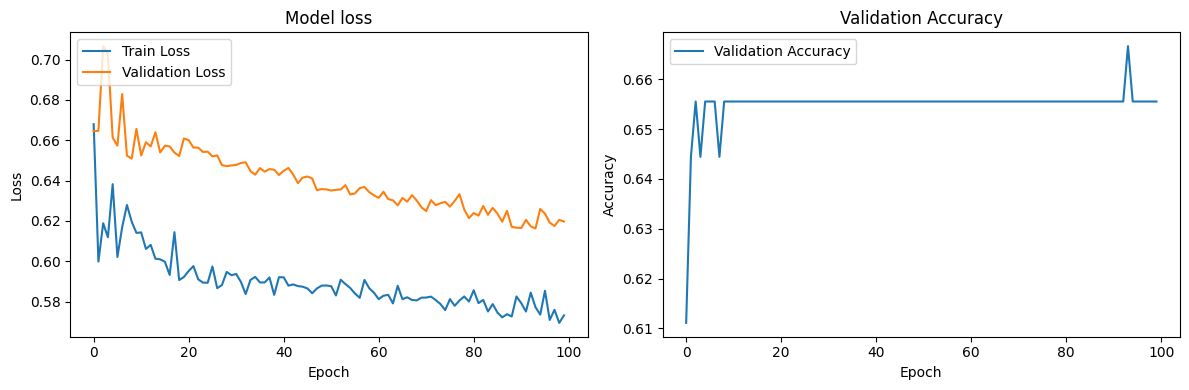

In [74]:
# Define the hyperparameters grid
param_grid = {
    'learning_rate': [0.001, 0.01],
    'batch_size': [32, 64],
    'epochs': [50, 100],
    'layers': [(1024, 512, 256), (256, 128, 64), (512, 256, 128)],
    'dropout_rate': [0.1, 0.2]
}

# Function to train and evaluate the model with given parameters
def train_evaluate(params):
    input_dim = X_train.shape[1]
    model = create_model(input_dim, params['layers'], params['dropout_rate'])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=params['epochs'] // 10, verbose=True)

    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

    best_val_loss = float('inf')
    early_stopping_patience = params['epochs'] // 5
    early_stopping_counter = 0
    num_epochs = params['epochs']

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_val_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                running_val_loss += loss.item() * X_batch.size(0)

                preds = (outputs > 0.5).float()
                correct_predictions += (preds == y_batch).sum().item()
                total_predictions += y_batch.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_accuracy = correct_predictions / total_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

        scheduler.step(epoch_val_loss)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping")
                break

    model.load_state_dict(torch.load('best_model.pth'))

    return model, train_losses, val_losses, val_accuracies

# Perform grid search
best_params = None
best_accuracy = 0

for lr in param_grid['learning_rate']:
    for bs in param_grid['batch_size']:
        for epochs in param_grid['epochs']:
            for layers in param_grid['layers']:
                for dropout_rate in param_grid['dropout_rate']:
                    params = {
                        'learning_rate': lr,
                        'batch_size': bs,
                        'epochs': epochs,
                        'layers': layers,
                        'dropout_rate': dropout_rate
                    }
                    model, train_losses, val_losses, val_accuracies = train_evaluate(params)
                    model.eval()
                    y_test_pred_prob = []
                    y_test_true = []
                    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)  # Ensure test_loader here as well
                    with torch.no_grad():
                        for X_batch, y_batch in test_loader:
                            outputs = model(X_batch)
                            y_test_pred_prob.append(outputs.numpy())
                            y_test_true.append(y_batch.numpy())
                    y_test_pred_prob = np.vstack(y_test_pred_prob).ravel()
                    y_test_true = np.vstack(y_test_true).ravel()
                    y_test_pred = (y_test_pred_prob > 0.5).astype(int)
                    test_accuracy = accuracy_score(y_test_true, y_test_pred)
                    if test_accuracy > best_accuracy:
                        best_accuracy = test_accuracy
                        best_params = params
                    print(f"Params: {params}, Test Accuracy: {test_accuracy}")

print(f"Best Params: {best_params}, Best Accuracy: {best_accuracy}")

# Load the best model
model, train_losses, val_losses, val_accuracies = train_evaluate(best_params)
model.eval()

# Evaluate the best model on the test set
y_test_pred_prob = []
y_test_true = []
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)  # Ensure test_loader here as well
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        y_test_pred_prob.append(outputs.numpy())
        y_test_true.append(y_batch.numpy())
y_test_pred_prob = np.vstack(y_test_pred_prob).ravel()
y_test_true = np.vstack(y_test_true).ravel()
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

test_accuracy = accuracy_score(y_test_true, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

# Generate ROC curve for test set
fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_pred_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (Test) - AUC: {roc_auc_test:.2f}')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix for test set
cm_test = confusion_matrix(y_test_true, y_test_pred)
print("Confusion Matrix (Test):\n", cm_test)
print("Classification Report (Test):\n", classification_report(y_test_true, y_test_pred))

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Results:

**1. principal_df**

*   SVM: Test accuracy = 0.64
*   MLP: Test accuracy = 0.68


**2. feature_dataset_list_env_rms**
*   SVM: Test accuracy = 0.64
*   MLP: Test accuracy = 0.68


**3. feature_dataset_list_cwt**
*  SVM: 0.64
*  MLP: 0.58
*  MLP with hyper parameter: 0.78


**4. feature_dataset_list_FFTstat**
*  SVM: 0.64
*  MLP (with hyper parameter): 0.68


**5. feature_dataset_list_DWTstat**
*  SVM: 0.64
*  MLP: 0.64


**6. feature_dataset_list_FFTstat**
*  SVM: 0.64
*  MLP: 0.68
*  MLP (hyper parameter): 0.74

**7. All features combined**
*  SVM: 0.68
*  MLP: 0.64
*  MLP (hyper parameter): 0.64


# 7. Conclusions

1. Accuracy generally around 60 ~ 70 % - shows data not robust enough for training and testing (only had 500 rows) --> need more data
2. Class imbalance could lead to biased model training
3. Model not complex enough: need a more robust model like decision tree clasifiers (random forest XGboost) to iteratively train
4. Need a more deeper and complex deep learning model (hyper parameter tuning) to capture more features. Could also try CNN, ResNet
5. More features could be extracted from signals, to generate more densely populated feature dataset
